In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 19:06:44,464] A new study created in memory with name: no-name-f5dc8a36-1f41-428e-8b88-7bee1b9b42ba
[I 2025-06-07 19:11:43,590] Trial 0 finished with value: 0.4242003262042999 and parameters: {'lr': 0.0032008243996842992, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3670369521701784}. Best is trial 0 with value: 0.4242003262042999.


Cross Validation Accuracies:
[0.3906252384185791, 0.3952586352825165, 0.3955139219760895, 0.5624872446060181, 0.3771165907382965]
Mean Cross Validation Accuracy:
0.4242003262042999
Standard Deviation of Cross Validation Accuracy:
0.0694664922495029


[I 2025-06-07 19:16:48,872] Trial 1 finished with value: 0.08973732739686965 and parameters: {'lr': 0.01146504299806448, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3212387182132595}. Best is trial 1 with value: 0.08973732739686965.


Cross Validation Accuracies:
[0.09744364768266678, 0.08860801160335541, 0.08223025500774384, 0.10915515571832657, 0.0712495669722557]
Mean Cross Validation Accuracy:
0.08973732739686965
Standard Deviation of Cross Validation Accuracy:
0.012929564606774972


[I 2025-06-07 19:21:37,604] Trial 2 finished with value: 0.23811514675617218 and parameters: {'lr': 0.004707713166357379, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4440005797309853}. Best is trial 1 with value: 0.08973732739686965.


Cross Validation Accuracies:
[0.2068740427494049, 0.2212696075439453, 0.21016304194927216, 0.3942878842353821, 0.15798115730285645]
Mean Cross Validation Accuracy:
0.23811514675617218
Standard Deviation of Cross Validation Accuracy:
0.0810585950180517


[I 2025-06-07 19:27:13,189] Trial 3 finished with value: 0.11638380438089371 and parameters: {'lr': 0.023882773155032386, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3204868526013414}. Best is trial 1 with value: 0.08973732739686965.


Cross Validation Accuracies:
[0.09107833355665207, 0.13075141608715057, 0.15305863320827484, 0.10369676351547241, 0.10333387553691864]
Mean Cross Validation Accuracy:
0.11638380438089371
Standard Deviation of Cross Validation Accuracy:
0.022463747853150876


[I 2025-06-07 19:32:36,978] Trial 4 finished with value: 0.09477360993623733 and parameters: {'lr': 0.005329195990976217, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3479309523155223}. Best is trial 1 with value: 0.08973732739686965.


Cross Validation Accuracies:
[0.10775958001613617, 0.09859233349561691, 0.08541716635227203, 0.10548979043960571, 0.07660917937755585]
Mean Cross Validation Accuracy:
0.09477360993623733
Standard Deviation of Cross Validation Accuracy:
0.01196281043217561


[I 2025-06-07 19:37:08,676] Trial 5 finished with value: 0.08906232267618179 and parameters: {'lr': 0.004856541974223604, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2624520342493487}. Best is trial 5 with value: 0.08906232267618179.


Cross Validation Accuracies:
[0.09235598146915436, 0.09216295927762985, 0.08357711136341095, 0.10506703704595566, 0.07214852422475815]
Mean Cross Validation Accuracy:
0.08906232267618179
Standard Deviation of Cross Validation Accuracy:
0.010888316112585464


[I 2025-06-07 19:42:34,635] Trial 6 finished with value: 1.05777245759964 and parameters: {'lr': 0.13202067170849072, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10498332339529504}. Best is trial 5 with value: 0.08906232267618179.


Cross Validation Accuracies:
[0.9184290766716003, 0.965877890586853, 1.4696601629257202, 1.243868112564087, 0.691027045249939]
Mean Cross Validation Accuracy:
1.05777245759964
Standard Deviation of Cross Validation Accuracy:
0.2707938187366569


[I 2025-06-07 19:47:57,710] Trial 7 finished with value: 0.0869301587343216 and parameters: {'lr': 0.005672614377669178, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2051887133782993}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.08536426723003387, 0.09319731593132019, 0.07774583250284195, 0.10585668683052063, 0.07248669117689133]
Mean Cross Validation Accuracy:
0.0869301587343216
Standard Deviation of Cross Validation Accuracy:
0.011772071565532456


[I 2025-06-07 19:53:35,038] Trial 8 finished with value: 4.872111988067627 and parameters: {'lr': 0.055390203454746455, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3139744012060768}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[5.141061782836914, 3.8347816467285156, 5.361265659332275, 5.281585216522217, 4.741865634918213]
Mean Cross Validation Accuracy:
4.872111988067627
Standard Deviation of Cross Validation Accuracy:
0.5607659013546721


[I 2025-06-07 20:00:37,421] Trial 9 finished with value: 0.08939088732004166 and parameters: {'lr': 0.2830371029460347, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4057092598848048}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09240926057100296, 0.09241210669279099, 0.08392646908760071, 0.10735253244638443, 0.0708540678024292]
Mean Cross Validation Accuracy:
0.08939088732004166
Standard Deviation of Cross Validation Accuracy:
0.011952678224336493


[I 2025-06-07 20:07:33,865] Trial 10 finished with value: 0.10385528951883316 and parameters: {'lr': 0.0010086365050907215, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20041101826535093}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.10325144976377487, 0.12518812716007233, 0.09472771733999252, 0.12034198641777039, 0.0757671669125557]
Mean Cross Validation Accuracy:
0.10385528951883316
Standard Deviation of Cross Validation Accuracy:
0.017885865728780963


[I 2025-06-07 20:13:32,239] Trial 11 finished with value: 0.5830747723579407 and parameters: {'lr': 0.0010643701146241615, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2105541584207127}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.33377256989479065, 0.5236472487449646, 0.38345053791999817, 0.6649910807609558, 1.0095124244689941]
Mean Cross Validation Accuracy:
0.5830747723579407
Standard Deviation of Cross Validation Accuracy:
0.24252521782736272


[I 2025-06-07 20:19:21,844] Trial 12 finished with value: 0.08866071254014969 and parameters: {'lr': 0.016082647897114874, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21739970302603195}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09076518565416336, 0.09250257164239883, 0.08430136740207672, 0.10494627803564072, 0.07078815996646881]
Mean Cross Validation Accuracy:
0.08866071254014969
Standard Deviation of Cross Validation Accuracy:
0.011161006742125876


[I 2025-06-07 20:25:18,827] Trial 13 finished with value: 0.08948106169700623 and parameters: {'lr': 0.03409324231476885, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13689814051378607}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09233509004116058, 0.09242108464241028, 0.08376366645097733, 0.10607592016458511, 0.07280954718589783]
Mean Cross Validation Accuracy:
0.08948106169700623
Standard Deviation of Cross Validation Accuracy:
0.010980041391189063


[I 2025-06-07 20:31:19,108] Trial 14 finished with value: 0.09005306214094162 and parameters: {'lr': 0.02016709008782367, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23618798902304544}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.0947338417172432, 0.09238409250974655, 0.08549238741397858, 0.10541903227567673, 0.07223595678806305]
Mean Cross Validation Accuracy:
0.09005306214094162
Standard Deviation of Cross Validation Accuracy:
0.01097000852620013


[I 2025-06-07 20:37:51,229] Trial 15 finished with value: 0.08851967751979828 and parameters: {'lr': 0.8480339816113106, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.49971371108581525}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09283501654863358, 0.09228288382291794, 0.08107534795999527, 0.10451293736696243, 0.07189220190048218]
Mean Cross Validation Accuracy:
0.08851967751979828
Standard Deviation of Cross Validation Accuracy:
0.01113965189059739


[I 2025-06-07 20:43:44,466] Trial 16 finished with value: 0.08871485739946365 and parameters: {'lr': 0.9883757423547669, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4878880686781079}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09425893425941467, 0.09241577982902527, 0.0807635560631752, 0.10495806485414505, 0.07117795199155807]
Mean Cross Validation Accuracy:
0.08871485739946365
Standard Deviation of Cross Validation Accuracy:
0.011653683089056304


[I 2025-06-07 20:50:46,482] Trial 17 finished with value: 0.3624073565006256 and parameters: {'lr': 0.6944779879915907, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.17258294576601502}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.3378053903579712, 0.37839454412460327, 0.3659254312515259, 0.3724530339241028, 0.3574583828449249]
Mean Cross Validation Accuracy:
0.3624073565006256
Standard Deviation of Cross Validation Accuracy:
0.014132457191181435


[I 2025-06-07 20:57:01,238] Trial 18 finished with value: 0.08931722491979599 and parameters: {'lr': 0.10474226447619528, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2703325864685781}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.0930032804608345, 0.0921824723482132, 0.08384564518928528, 0.10525891929864883, 0.07229580730199814]
Mean Cross Validation Accuracy:
0.08931722491979599
Standard Deviation of Cross Validation Accuracy:
0.010914221093722037


[I 2025-06-07 21:03:02,648] Trial 19 finished with value: 0.08903933763504028 and parameters: {'lr': 0.2936367596665813, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4891516713904264}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09212498366832733, 0.09211567044258118, 0.0834740474820137, 0.10536807775497437, 0.07211390882730484]
Mean Cross Validation Accuracy:
0.08903933763504028
Standard Deviation of Cross Validation Accuracy:
0.01098230744154372


[I 2025-06-07 21:10:10,894] Trial 20 finished with value: 0.1102657899260521 and parameters: {'lr': 0.002307393009480676, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41819260912526185}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09659311920404434, 0.10632016509771347, 0.1253131777048111, 0.14325551688671112, 0.07984697073698044]
Mean Cross Validation Accuracy:
0.1102657899260521
Standard Deviation of Cross Validation Accuracy:
0.022102309402951825


[I 2025-06-07 21:16:30,680] Trial 21 finished with value: 0.08866239786148071 and parameters: {'lr': 0.0113196457867163, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1656755686786203}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.08994574099779129, 0.09186860918998718, 0.08417446911334991, 0.10513404756784439, 0.07218912243843079]
Mean Cross Validation Accuracy:
0.08866239786148071
Standard Deviation of Cross Validation Accuracy:
0.010721495346729101


[I 2025-06-07 21:22:54,238] Trial 22 finished with value: 0.08956806212663651 and parameters: {'lr': 0.013034632513941236, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2762754492083647}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09308647364377975, 0.09281869232654572, 0.08328104764223099, 0.10602069646120071, 0.07263340055942535]
Mean Cross Validation Accuracy:
0.08956806212663651
Standard Deviation of Cross Validation Accuracy:
0.011135028570870507


[I 2025-06-07 21:28:56,980] Trial 23 finished with value: 0.08918273448944092 and parameters: {'lr': 0.05547823791283353, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2213253260855278}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09241203963756561, 0.09176340699195862, 0.08412359654903412, 0.1049690768122673, 0.07264555245637894]
Mean Cross Validation Accuracy:
0.08918273448944092
Standard Deviation of Cross Validation Accuracy:
0.010633627344731493


[I 2025-06-07 21:35:18,288] Trial 24 finished with value: 0.08740058243274688 and parameters: {'lr': 0.0077385789033844535, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1744462899108802}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.08097796887159348, 0.09911026060581207, 0.0798690989613533, 0.10503672808408737, 0.07200885564088821]
Mean Cross Validation Accuracy:
0.08740058243274688
Standard Deviation of Cross Validation Accuracy:
0.012514221176110495


[I 2025-06-07 21:42:32,339] Trial 25 finished with value: 0.08873605877161025 and parameters: {'lr': 0.008177771762562838, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10569769761465486}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09221739321947098, 0.09235582500696182, 0.07900761067867279, 0.10813607275485992, 0.07196339219808578]
Mean Cross Validation Accuracy:
0.08873605877161025
Standard Deviation of Cross Validation Accuracy:
0.012470348719826076


[I 2025-06-07 21:48:49,131] Trial 26 finished with value: 0.08949232995510101 and parameters: {'lr': 0.002294322890497522, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1701352422335918}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09229304641485214, 0.09209708869457245, 0.0858348160982132, 0.10515845566987991, 0.07207824289798737]
Mean Cross Validation Accuracy:
0.08949232995510101
Standard Deviation of Cross Validation Accuracy:
0.010739498231631587


[I 2025-06-07 21:54:55,558] Trial 27 finished with value: 0.08917378187179566 and parameters: {'lr': 0.007766892663479459, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1434844316296862}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09268121421337128, 0.09222635626792908, 0.08278582990169525, 0.10579532384872437, 0.0723801851272583]
Mean Cross Validation Accuracy:
0.08917378187179566
Standard Deviation of Cross Validation Accuracy:
0.011142053417175026


[I 2025-06-07 22:01:29,890] Trial 28 finished with value: 0.0889674887061119 and parameters: {'lr': 0.03613055161633803, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24865765333745854}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09243574738502502, 0.09250631183385849, 0.08384405076503754, 0.10433255136013031, 0.07171878218650818]
Mean Cross Validation Accuracy:
0.0889674887061119
Standard Deviation of Cross Validation Accuracy:
0.010811149158999722


[I 2025-06-07 22:06:59,187] Trial 29 finished with value: 3.394224429130554 and parameters: {'lr': 0.35790899847949514, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.37831040316204423}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[5.155346393585205, 2.9424571990966797, 2.414266586303711, 1.6943553686141968, 4.7646965980529785]
Mean Cross Validation Accuracy:
3.394224429130554
Standard Deviation of Cross Validation Accuracy:
1.3441510604263665


[I 2025-06-07 22:12:33,004] Trial 30 finished with value: 0.4319415748119354 and parameters: {'lr': 0.0028734867046297293, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1913707387004232}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.3954299986362457, 0.4037906527519226, 0.3967963755130768, 0.5702399611473083, 0.39345088601112366]
Mean Cross Validation Accuracy:
0.4319415748119354
Standard Deviation of Cross Validation Accuracy:
0.0692368852978636


[I 2025-06-07 22:18:46,621] Trial 31 finished with value: 0.09304853975772857 and parameters: {'lr': 0.022891605606989586, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.22443945568648582}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.09236419945955276, 0.09338623285293579, 0.09147385507822037, 0.10611593723297119, 0.08190247416496277]
Mean Cross Validation Accuracy:
0.09304853975772857
Standard Deviation of Cross Validation Accuracy:
0.007720798470162923


[I 2025-06-07 22:24:23,019] Trial 32 finished with value: 0.08922053277492523 and parameters: {'lr': 0.013019546016631273, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2925918062537751}. Best is trial 7 with value: 0.0869301587343216.


Cross Validation Accuracies:
[0.0929597020149231, 0.09239734709262848, 0.0820804014801979, 0.10526864975690842, 0.07339656352996826]
Mean Cross Validation Accuracy:
0.08922053277492523
Standard Deviation of Cross Validation Accuracy:
0.010798102352295206


[I 2025-06-07 22:30:36,312] Trial 33 finished with value: 0.08147664666175843 and parameters: {'lr': 0.007007012090822239, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.15277335227857256}. Best is trial 33 with value: 0.08147664666175843.


Cross Validation Accuracies:
[0.07940903306007385, 0.09233908355236053, 0.08182425051927567, 0.0799180343747139, 0.07389283180236816]
Mean Cross Validation Accuracy:
0.08147664666175843
Standard Deviation of Cross Validation Accuracy:
0.006038740095960088


[I 2025-06-07 22:36:21,851] Trial 34 finished with value: 0.08200624287128448 and parameters: {'lr': 0.001588927215053713, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1411480199793824}. Best is trial 33 with value: 0.08147664666175843.


Cross Validation Accuracies:
[0.08443368971347809, 0.08524000644683838, 0.07083764672279358, 0.09745656698942184, 0.07206330448389053]
Mean Cross Validation Accuracy:
0.08200624287128448
Standard Deviation of Cross Validation Accuracy:
0.00978429153381429


[I 2025-06-07 22:42:14,355] Trial 35 finished with value: 0.08342963606119155 and parameters: {'lr': 0.0014747278711237692, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.127516667947892}. Best is trial 33 with value: 0.08147664666175843.


Cross Validation Accuracies:
[0.07195992022752762, 0.08771567791700363, 0.07121545076370239, 0.10342975705862045, 0.0828273743391037]
Mean Cross Validation Accuracy:
0.08342963606119155
Standard Deviation of Cross Validation Accuracy:
0.011827750569485842


[I 2025-06-07 22:47:50,021] Trial 36 finished with value: 0.08086899816989898 and parameters: {'lr': 0.0015835074964760925, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13270307977917906}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.07596877962350845, 0.09055814146995544, 0.07674577832221985, 0.09447494149208069, 0.0665973499417305]
Mean Cross Validation Accuracy:
0.08086899816989898
Standard Deviation of Cross Validation Accuracy:
0.010234199709197778


[I 2025-06-07 22:53:40,904] Trial 37 finished with value: 0.39485785365104675 and parameters: {'lr': 0.0016352145000145212, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13338760998439733}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.34597551822662354, 0.3710474967956543, 0.38369959592819214, 0.5142815113067627, 0.3592851459980011]
Mean Cross Validation Accuracy:
0.39485785365104675
Standard Deviation of Cross Validation Accuracy:
0.061005491659645354


[I 2025-06-07 22:58:54,782] Trial 38 finished with value: 0.08152578175067901 and parameters: {'lr': 0.001588627198998909, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12244946027446939}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.07165664434432983, 0.09205776453018188, 0.0692698284983635, 0.09590775519609451, 0.07873691618442535]
Mean Cross Validation Accuracy:
0.08152578175067901
Standard Deviation of Cross Validation Accuracy:
0.010706538711155542


[I 2025-06-07 23:04:12,927] Trial 39 finished with value: 0.08672934621572495 and parameters: {'lr': 0.0034819152605123755, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10158897196604866}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.0818198174238205, 0.0923893004655838, 0.08384710550308228, 0.1052827537059784, 0.07030775398015976]
Mean Cross Validation Accuracy:
0.08672934621572495
Standard Deviation of Cross Validation Accuracy:
0.011647690652186952


[I 2025-06-07 23:10:51,956] Trial 40 finished with value: 0.08904953449964523 and parameters: {'lr': 0.003971195283963502, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15367543366431585}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.09148083627223969, 0.0922946184873581, 0.08472375571727753, 0.10430994629859924, 0.07243851572275162]
Mean Cross Validation Accuracy:
0.08904953449964523
Standard Deviation of Cross Validation Accuracy:
0.010430342981423776


[I 2025-06-07 23:16:28,124] Trial 41 finished with value: 0.0839114859700203 and parameters: {'lr': 0.001376526172418527, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12166262915162948}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.09191252291202545, 0.08805841207504272, 0.06825954467058182, 0.09985024482011795, 0.07147670537233353]
Mean Cross Validation Accuracy:
0.0839114859700203
Standard Deviation of Cross Validation Accuracy:
0.012123239310539814


[I 2025-06-07 23:21:53,219] Trial 42 finished with value: 0.08563250452280044 and parameters: {'lr': 0.00210350284253392, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12217891410181352}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.10519701987504959, 0.0860321894288063, 0.07592863589525223, 0.08446717262268066, 0.07653750479221344]
Mean Cross Validation Accuracy:
0.08563250452280044
Standard Deviation of Cross Validation Accuracy:
0.010594074701171505


[I 2025-06-07 23:27:29,870] Trial 43 finished with value: 0.08187492340803146 and parameters: {'lr': 0.0018533594636082765, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1548472547856853}. Best is trial 36 with value: 0.08086899816989898.


Cross Validation Accuracies:
[0.08591015636920929, 0.08798561245203018, 0.07223067432641983, 0.09336506575345993, 0.06988310813903809]
Mean Cross Validation Accuracy:
0.08187492340803146
Standard Deviation of Cross Validation Accuracy:
0.009191976616108854


[I 2025-06-07 23:33:16,763] Trial 44 finished with value: 0.07967086285352706 and parameters: {'lr': 0.0018788770055781748, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18922799970442922}. Best is trial 44 with value: 0.07967086285352706.


Cross Validation Accuracies:
[0.08591632544994354, 0.08987956494092941, 0.06649983674287796, 0.09101030230522156, 0.06504828482866287]
Mean Cross Validation Accuracy:
0.07967086285352706
Standard Deviation of Cross Validation Accuracy:
0.011481306592299132


[I 2025-06-07 23:38:49,163] Trial 45 finished with value: 0.30248114466667175 and parameters: {'lr': 0.0030700664425773747, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18840227261460676}. Best is trial 44 with value: 0.07967086285352706.


Cross Validation Accuracies:
[0.24834957718849182, 0.26782411336898804, 0.2891761064529419, 0.4358021318912506, 0.2712537944316864]
Mean Cross Validation Accuracy:
0.30248114466667175
Standard Deviation of Cross Validation Accuracy:
0.06790875274236297


[I 2025-06-07 23:43:59,347] Trial 46 finished with value: 0.08240946829319 and parameters: {'lr': 0.004312253411308853, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15907670532174645}. Best is trial 44 with value: 0.07967086285352706.


Cross Validation Accuracies:
[0.07458821684122086, 0.08171389997005463, 0.08229858428239822, 0.10213297605514526, 0.07131366431713104]
Mean Cross Validation Accuracy:
0.08240946829319
Standard Deviation of Cross Validation Accuracy:
0.010712625347149627


[I 2025-06-07 23:49:25,581] Trial 47 finished with value: 0.3707176625728607 and parameters: {'lr': 0.005606261083999019, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18910689040650924}. Best is trial 44 with value: 0.07967086285352706.


Cross Validation Accuracies:
[0.29811689257621765, 0.36335715651512146, 0.4484943747520447, 0.37824466824531555, 0.36537522077560425]
Mean Cross Validation Accuracy:
0.3707176625728607
Standard Deviation of Cross Validation Accuracy:
0.04787371577324105


[I 2025-06-07 23:55:09,520] Trial 48 finished with value: 0.07962557524442673 and parameters: {'lr': 0.0010477434467722115, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15043631848135502}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08059937506914139, 0.08068758249282837, 0.07605490833520889, 0.09784536808729172, 0.06294064223766327]
Mean Cross Validation Accuracy:
0.07962557524442673
Standard Deviation of Cross Validation Accuracy:
0.011181892937673427


[I 2025-06-08 00:00:55,738] Trial 49 finished with value: 0.08162513822317123 and parameters: {'lr': 0.0010425975211069197, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11442049414405744}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08136029541492462, 0.08814879506826401, 0.0680900514125824, 0.09724517911672592, 0.07328137010335922]
Mean Cross Validation Accuracy:
0.08162513822317123
Standard Deviation of Cross Validation Accuracy:
0.010386827805151037


[I 2025-06-08 00:06:03,043] Trial 50 finished with value: 0.42184960246086123 and parameters: {'lr': 0.0012880400671103132, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1466803343097107}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.3875572085380554, 0.3923947215080261, 0.381204754114151, 0.5542712211608887, 0.3938201069831848]
Mean Cross Validation Accuracy:
0.42184960246086123
Standard Deviation of Cross Validation Accuracy:
0.06635766678523017


[I 2025-06-08 00:11:37,744] Trial 51 finished with value: 0.08236290216445923 and parameters: {'lr': 0.0010042586846252745, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11497411537474037}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08306967467069626, 0.08570325374603271, 0.07525704056024551, 0.09880188852548599, 0.06898265331983566]
Mean Cross Validation Accuracy:
0.08236290216445923
Standard Deviation of Cross Validation Accuracy:
0.010113575796170273


[I 2025-06-08 00:16:53,596] Trial 52 finished with value: 0.08189047574996948 and parameters: {'lr': 0.0026774277103366853, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11806874433436024}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.07105856388807297, 0.09917920082807541, 0.07426045089960098, 0.09852587431669235, 0.0664282888174057]
Mean Cross Validation Accuracy:
0.08189047574996948
Standard Deviation of Cross Validation Accuracy:
0.014073118480555301


[I 2025-06-08 00:22:06,085] Trial 53 finished with value: 0.0826911062002182 and parameters: {'lr': 0.0010935352161875892, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1767386792210781}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.0743216946721077, 0.0905107855796814, 0.0693645253777504, 0.11122345179319382, 0.0680350735783577]
Mean Cross Validation Accuracy:
0.0826911062002182
Standard Deviation of Cross Validation Accuracy:
0.016356565829001343


[I 2025-06-08 00:27:37,770] Trial 54 finished with value: 0.0835683986544609 and parameters: {'lr': 0.001947389305418837, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10009837638470004}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08130012452602386, 0.08524682372808456, 0.07385732233524323, 0.10329081118106842, 0.07414691150188446]
Mean Cross Validation Accuracy:
0.0835683986544609
Standard Deviation of Cross Validation Accuracy:
0.010770377500933046


[I 2025-06-08 00:34:19,152] Trial 55 finished with value: 0.08104628473520278 and parameters: {'lr': 0.0012933254946152191, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13803721193157512}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.09791586548089981, 0.08383812010288239, 0.06855057924985886, 0.08871272206306458, 0.06621413677930832]
Mean Cross Validation Accuracy:
0.08104628473520278
Standard Deviation of Cross Validation Accuracy:
0.012060569050586709


[I 2025-06-08 00:40:05,557] Trial 56 finished with value: 0.09037654399871826 and parameters: {'lr': 0.0025797454267188994, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20041736169396068}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08985443413257599, 0.09685590118169785, 0.0821099504828453, 0.10417448729276657, 0.0788879469037056]
Mean Cross Validation Accuracy:
0.09037654399871826
Standard Deviation of Cross Validation Accuracy:
0.009305507390045221


[I 2025-06-08 00:46:27,797] Trial 57 finished with value: 0.09375789761543274 and parameters: {'lr': 0.0013653882603470913, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1337902891875608}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.06844376772642136, 0.09623944014310837, 0.09596788138151169, 0.11803941428661346, 0.09009898453950882]
Mean Cross Validation Accuracy:
0.09375789761543274
Standard Deviation of Cross Validation Accuracy:
0.015841887200398374


[I 2025-06-08 00:52:55,995] Trial 58 finished with value: 0.08824993669986725 and parameters: {'lr': 0.003375733629793864, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33005299209459193}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.09095320850610733, 0.08780401200056076, 0.08573092520236969, 0.10406867414712906, 0.0726928636431694]
Mean Cross Validation Accuracy:
0.08824993669986725
Standard Deviation of Cross Validation Accuracy:
0.010060883884999629


[I 2025-06-08 00:59:11,527] Trial 59 finished with value: 0.08260877877473831 and parameters: {'lr': 0.0019682285653340797, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15974494337706752}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.08205834031105042, 0.08599580079317093, 0.07359365373849869, 0.09063476324081421, 0.08076133579015732]
Mean Cross Validation Accuracy:
0.08260877877473831
Standard Deviation of Cross Validation Accuracy:
0.005672333775539977


[I 2025-06-08 01:05:48,487] Trial 60 finished with value: 0.08869744539260864 and parameters: {'lr': 0.004761675628905626, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1849096875420153}. Best is trial 48 with value: 0.07962557524442673.


Cross Validation Accuracies:
[0.09207750856876373, 0.09115613996982574, 0.08335988968610764, 0.10581335425376892, 0.07108033448457718]
Mean Cross Validation Accuracy:
0.08869744539260864
Standard Deviation of Cross Validation Accuracy:
0.011395406442143817


[I 2025-06-08 01:11:39,843] Trial 61 finished with value: 0.07779419869184494 and parameters: {'lr': 0.0011968925324844382, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11132049236037105}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.05954994261264801, 0.09059851616621017, 0.06778350472450256, 0.09480638056993484, 0.07623264938592911]
Mean Cross Validation Accuracy:
0.07779419869184494
Standard Deviation of Cross Validation Accuracy:
0.013333193076404848


[I 2025-06-08 01:17:16,894] Trial 62 finished with value: 0.08362290561199189 and parameters: {'lr': 0.0012713060848493559, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1449331008669015}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08692289888858795, 0.09207950532436371, 0.06807177513837814, 0.097984179854393, 0.0730561688542366]
Mean Cross Validation Accuracy:
0.08362290561199189
Standard Deviation of Cross Validation Accuracy:
0.011332641500562655


[I 2025-06-08 01:23:23,977] Trial 63 finished with value: 0.0812414214015007 and parameters: {'lr': 0.0016341499457830956, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1332445440027007}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07924789935350418, 0.09075422585010529, 0.07054617255926132, 0.08629745244979858, 0.07936135679483414]
Mean Cross Validation Accuracy:
0.0812414214015007
Standard Deviation of Cross Validation Accuracy:
0.006898608835370429


[I 2025-06-08 01:29:49,242] Trial 64 finished with value: 0.08351575136184693 and parameters: {'lr': 0.0022322861394204205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1673654444440864}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07847777009010315, 0.08242611587047577, 0.07322683930397034, 0.11275874823331833, 0.07068928331136703]
Mean Cross Validation Accuracy:
0.08351575136184693
Standard Deviation of Cross Validation Accuracy:
0.015179600922343661


[I 2025-06-08 01:35:38,905] Trial 65 finished with value: 0.08911846429109574 and parameters: {'lr': 0.006758202513861013, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.13347683867588062}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09525749087333679, 0.09127654880285263, 0.08172004669904709, 0.10540152341127396, 0.0719367116689682]
Mean Cross Validation Accuracy:
0.08911846429109574
Standard Deviation of Cross Validation Accuracy:
0.011466753651168128


[I 2025-06-08 01:42:18,750] Trial 66 finished with value: 0.08377231359481811 and parameters: {'lr': 0.0011931684254103147, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15517458111419666}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07673055678606033, 0.07598704844713211, 0.06968604773283005, 0.1239355206489563, 0.07252239435911179]
Mean Cross Validation Accuracy:
0.08377231359481811
Standard Deviation of Cross Validation Accuracy:
0.020239878764417348


[I 2025-06-08 01:47:59,412] Trial 67 finished with value: 0.08141186982393264 and parameters: {'lr': 0.001770010495270129, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.178681426442976}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07677803933620453, 0.09461473673582077, 0.06604201346635818, 0.09734200686216354, 0.07228255271911621]
Mean Cross Validation Accuracy:
0.08141186982393264
Standard Deviation of Cross Validation Accuracy:
0.012402695360215946


[I 2025-06-08 01:53:47,778] Trial 68 finished with value: 0.10314710587263107 and parameters: {'lr': 0.001803699946015081, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.21214932228156128}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.10215631872415543, 0.10279954224824905, 0.08849342912435532, 0.13240230083465576, 0.08988393843173981]
Mean Cross Validation Accuracy:
0.10314710587263107
Standard Deviation of Cross Validation Accuracy:
0.015796270095948146


[I 2025-06-08 01:59:41,599] Trial 69 finished with value: 0.08245184272527695 and parameters: {'lr': 0.0024938077812715364, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.17731805289986485}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08530369400978088, 0.0900748148560524, 0.07965169847011566, 0.0913529023528099, 0.06587610393762589]
Mean Cross Validation Accuracy:
0.08245184272527695
Standard Deviation of Cross Validation Accuracy:
0.009252756849226676


[I 2025-06-08 02:05:39,150] Trial 70 finished with value: 0.28240143954753877 and parameters: {'lr': 0.0037370204419633008, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2532962761116857}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.24074320495128632, 0.26546263694763184, 0.24455180764198303, 0.40793535113334656, 0.25331419706344604]
Mean Cross Validation Accuracy:
0.28240143954753877
Standard Deviation of Cross Validation Accuracy:
0.06333996654868536


[I 2025-06-08 02:11:54,974] Trial 71 finished with value: 0.08436259776353836 and parameters: {'lr': 0.001585866203944438, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14198435457579725}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07527553290128708, 0.09202291816473007, 0.0764591321349144, 0.10962339490652084, 0.06843201071023941]
Mean Cross Validation Accuracy:
0.08436259776353836
Standard Deviation of Cross Validation Accuracy:
0.0148027801548504


[I 2025-06-08 02:18:11,635] Trial 72 finished with value: 0.07881875187158585 and parameters: {'lr': 0.0013086437766900196, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1106004933979434}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07927001267671585, 0.08461666107177734, 0.0689302310347557, 0.08482374995946884, 0.07645310461521149]
Mean Cross Validation Accuracy:
0.07881875187158585
Standard Deviation of Cross Validation Accuracy:
0.0058865698114505625


[I 2025-06-08 02:24:31,716] Trial 73 finished with value: 0.08154934197664261 and parameters: {'lr': 0.0010061833595836852, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10645130664722266}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.074883371591568, 0.09304985404014587, 0.0692739263176918, 0.1007150188088417, 0.06982453912496567]
Mean Cross Validation Accuracy:
0.08154934197664261
Standard Deviation of Cross Validation Accuracy:
0.012900983984522076


[I 2025-06-08 02:30:38,400] Trial 74 finished with value: 0.08271080255508423 and parameters: {'lr': 0.0012693270643707834, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22976100365303848}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08457978069782257, 0.08746486157178879, 0.07040459662675858, 0.11041834205389023, 0.06068643182516098]
Mean Cross Validation Accuracy:
0.08271080255508423
Standard Deviation of Cross Validation Accuracy:
0.01691341190836252


[I 2025-06-08 02:36:23,410] Trial 75 finished with value: 0.08093721866607666 and parameters: {'lr': 0.0017685219514398782, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11035639513115747}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08370974659919739, 0.09002222865819931, 0.06718399375677109, 0.09846499562263489, 0.06530512869358063]
Mean Cross Validation Accuracy:
0.08093721866607666
Standard Deviation of Cross Validation Accuracy:
0.012891553165153615


[I 2025-06-08 02:41:54,404] Trial 76 finished with value: 0.9893320679664612 and parameters: {'lr': 0.1251290121869442, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11112860580527616}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.623445451259613, 1.415218710899353, 0.7989768981933594, 0.86725914478302, 1.2417601346969604]
Mean Cross Validation Accuracy:
0.9893320679664612
Standard Deviation of Cross Validation Accuracy:
0.2932948233505074


[I 2025-06-08 02:48:01,037] Trial 77 finished with value: 0.08523124605417251 and parameters: {'lr': 0.003055896057890602, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1346499929893971}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08670524507761002, 0.09062130749225616, 0.0690038874745369, 0.10442398488521576, 0.07540180534124374]
Mean Cross Validation Accuracy:
0.08523124605417251
Standard Deviation of Cross Validation Accuracy:
0.012325029253231829


[I 2025-06-08 02:54:34,600] Trial 78 finished with value: 0.07973055616021156 and parameters: {'lr': 0.001479247795342457, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12708294020743485}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.06189042702317238, 0.09519457817077637, 0.07810722291469574, 0.08806394040584564, 0.07539661228656769]
Mean Cross Validation Accuracy:
0.07973055616021156
Standard Deviation of Cross Validation Accuracy:
0.011386568909735204


[I 2025-06-08 03:01:29,575] Trial 79 finished with value: 0.08277964890003205 and parameters: {'lr': 0.0021817174193854284, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12411280408108857}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.06877719610929489, 0.09893442690372467, 0.085545614361763, 0.08688002079725266, 0.073760986328125]
Mean Cross Validation Accuracy:
0.08277964890003205
Standard Deviation of Cross Validation Accuracy:
0.010609857922916176


[I 2025-06-08 03:07:41,669] Trial 80 finished with value: 0.08746389895677567 and parameters: {'lr': 0.0013705995285101988, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11530238615990844}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09354076534509659, 0.07538899779319763, 0.0777025893330574, 0.11962766945362091, 0.07105947285890579]
Mean Cross Validation Accuracy:
0.08746389895677567
Standard Deviation of Cross Validation Accuracy:
0.017785544900036008


[I 2025-06-08 03:14:00,718] Trial 81 finished with value: 0.08051470667123795 and parameters: {'lr': 0.00149761024724932, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12857233915887897}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09455293416976929, 0.08773186802864075, 0.06610104441642761, 0.08395662158727646, 0.07023106515407562]
Mean Cross Validation Accuracy:
0.08051470667123795
Standard Deviation of Cross Validation Accuracy:
0.010719262755411931


[I 2025-06-08 03:20:08,904] Trial 82 finished with value: 0.08435174077749252 and parameters: {'lr': 0.0012225075821633046, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1282467164599784}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08769812434911728, 0.07455185800790787, 0.07683943957090378, 0.10046666860580444, 0.08220261335372925]
Mean Cross Validation Accuracy:
0.08435174077749252
Standard Deviation of Cross Validation Accuracy:
0.009251813901282605


[I 2025-06-08 03:26:28,404] Trial 83 finished with value: 0.08863760083913803 and parameters: {'lr': 0.0014646949401807816, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10619566967560755}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.0996435210108757, 0.08883344382047653, 0.06864441186189651, 0.10275698453187943, 0.08330964297056198]
Mean Cross Validation Accuracy:
0.08863760083913803
Standard Deviation of Cross Validation Accuracy:
0.012236342343133968


[I 2025-06-08 03:32:57,684] Trial 84 finished with value: 0.083768592774868 and parameters: {'lr': 0.0020785927926409878, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14475260171870066}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09312991797924042, 0.09327662736177444, 0.06687786430120468, 0.09179425984621048, 0.07376429438591003]
Mean Cross Validation Accuracy:
0.083768592774868
Standard Deviation of Cross Validation Accuracy:
0.011205633920971951


[I 2025-06-08 03:41:22,217] Trial 85 finished with value: 0.08446053564548492 and parameters: {'lr': 0.0011680416283806672, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.16185964330229738}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09570196270942688, 0.09638421982526779, 0.06874909996986389, 0.08916770666837692, 0.07229968905448914]
Mean Cross Validation Accuracy:
0.08446053564548492
Standard Deviation of Cross Validation Accuracy:
0.011708431036571862


[I 2025-06-08 03:49:31,850] Trial 86 finished with value: 0.08632480949163437 and parameters: {'lr': 0.002562545527870218, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.45251295605232755}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.09163311123847961, 0.09409956634044647, 0.08037612587213516, 0.10109389573335648, 0.06442134827375412]
Mean Cross Validation Accuracy:
0.08632480949163437
Standard Deviation of Cross Validation Accuracy:
0.012821070704408572


[I 2025-06-08 03:57:13,522] Trial 87 finished with value: 3.445389485359192 and parameters: {'lr': 0.05952038694794382, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10160725153310068}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[4.57489538192749, 1.301201343536377, 1.1250888109207153, 5.954947471618652, 4.270814418792725]
Mean Cross Validation Accuracy:
3.445389485359192
Standard Deviation of Cross Validation Accuracy:
1.909781620230343


[I 2025-06-08 04:04:36,118] Trial 88 finished with value: 0.38796523213386536 and parameters: {'lr': 0.0017245559069118278, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12581780907198492}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.34525156021118164, 0.33993613719940186, 0.35183411836624146, 0.5383780002593994, 0.3644263446331024]
Mean Cross Validation Accuracy:
0.38796523213386536
Standard Deviation of Cross Validation Accuracy:
0.07565023351106141


[I 2025-06-08 04:11:54,808] Trial 89 finished with value: 0.0836868241429329 and parameters: {'lr': 0.0010085161252507508, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15032878479027081}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.07659059762954712, 0.08590389043092728, 0.07741726189851761, 0.0924997627735138, 0.08602260798215866]
Mean Cross Validation Accuracy:
0.0836868241429329
Standard Deviation of Cross Validation Accuracy:
0.0059615937104303155


[I 2025-06-08 04:18:00,753] Trial 90 finished with value: 0.08377537578344345 and parameters: {'lr': 0.001491727475450022, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11171999880519635}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08740205317735672, 0.09678816795349121, 0.07013971358537674, 0.09313566237688065, 0.07141128182411194]
Mean Cross Validation Accuracy:
0.08377537578344345
Standard Deviation of Cross Validation Accuracy:
0.011035421306924548


[I 2025-06-08 04:23:42,333] Trial 91 finished with value: 0.08476373255252838 and parameters: {'lr': 0.0016288806577598868, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13510749395641752}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08516167849302292, 0.08300241827964783, 0.07482320815324783, 0.09957320988178253, 0.0812581479549408]
Mean Cross Validation Accuracy:
0.08476373255252838
Standard Deviation of Cross Validation Accuracy:
0.008169263815162744


[I 2025-06-08 04:29:17,091] Trial 92 finished with value: 0.08123784214258194 and parameters: {'lr': 0.0019071049081850126, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12061822722919104}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08809210360050201, 0.07967635989189148, 0.07248887419700623, 0.08828950673341751, 0.07764236629009247]
Mean Cross Validation Accuracy:
0.08123784214258194
Standard Deviation of Cross Validation Accuracy:
0.0061419375961163985


[I 2025-06-08 04:34:42,284] Trial 93 finished with value: 0.0855790138244629 and parameters: {'lr': 0.002854992009781278, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11630103231360865}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08377669751644135, 0.0895468220114708, 0.07263442873954773, 0.1116395890712738, 0.07029753178358078]
Mean Cross Validation Accuracy:
0.0855790138244629
Standard Deviation of Cross Validation Accuracy:
0.014827214198656142


[I 2025-06-08 04:40:05,101] Trial 94 finished with value: 0.08283446431159973 and parameters: {'lr': 0.0019264872649441109, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12125223919738885}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08668489754199982, 0.08703967928886414, 0.0747435912489891, 0.08404196053743362, 0.08166219294071198]
Mean Cross Validation Accuracy:
0.08283446431159973
Standard Deviation of Cross Validation Accuracy:
0.004490081586885978


[I 2025-06-08 04:44:54,853] Trial 95 finished with value: 0.08498603254556655 and parameters: {'lr': 0.00230278210170998, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1667185969563481}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08128923922777176, 0.08662862330675125, 0.0714644342660904, 0.10441484302282333, 0.08113302290439606]
Mean Cross Validation Accuracy:
0.08498603254556655
Standard Deviation of Cross Validation Accuracy:
0.010876785969493654


[I 2025-06-08 04:50:04,758] Trial 96 finished with value: 0.08262728154659271 and parameters: {'lr': 0.0011382139169734237, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1450189255974309}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08657825738191605, 0.08297740668058395, 0.07001297175884247, 0.1008882001042366, 0.07267957180738449]
Mean Cross Validation Accuracy:
0.08262728154659271
Standard Deviation of Cross Validation Accuracy:
0.011020632329467615


[I 2025-06-08 04:54:57,895] Trial 97 finished with value: 0.08288337737321853 and parameters: {'lr': 0.0013605081635956937, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12694062868981906}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08916544169187546, 0.08644887059926987, 0.07653800398111343, 0.09230034798383713, 0.0699642226099968]
Mean Cross Validation Accuracy:
0.08288337737321853
Standard Deviation of Cross Validation Accuracy:
0.008342957902462712


[I 2025-06-08 05:00:38,493] Trial 98 finished with value: 0.08631991147994995 and parameters: {'lr': 0.001473851855495392, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11170010461839198}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08870436996221542, 0.08408213406801224, 0.06548451632261276, 0.10274538397789001, 0.09058315306901932]
Mean Cross Validation Accuracy:
0.08631991147994995
Standard Deviation of Cross Validation Accuracy:
0.012106017982712339


[I 2025-06-08 05:05:10,242] Trial 99 finished with value: 0.08689131885766983 and parameters: {'lr': 0.0019464698953086338, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1002633959022978}. Best is trial 61 with value: 0.07779419869184494.


Cross Validation Accuracies:
[0.08658526092767715, 0.0947071984410286, 0.08302101492881775, 0.10380049049854279, 0.06634262949228287]
Mean Cross Validation Accuracy:
0.08689131885766983
Standard Deviation of Cross Validation Accuracy:
0.01252461271126124
Number of finished trials: 100
Best trial: {'lr': 0.0011968925324844382, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11132049236037105}
Best hyperparameters:  {'lr': 0.0011968925324844382, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11132049236037105}
Fold 1:
Epoch 1/100
19/19 [==============================] - 31s 457ms/step - loss: 0.1614 - val_loss: 0.1165
Epoch 2/100
19/19 [==============================] - 2s 119ms/step - loss: 0.1021 - val_loss: 0.0856
Epoch 3/100
19/19 [==============================] - 2s 131ms/step - loss: 0.0986 - val_loss: 0.1161
Epoch 4/100
19/19 [==============================] - 2s 1

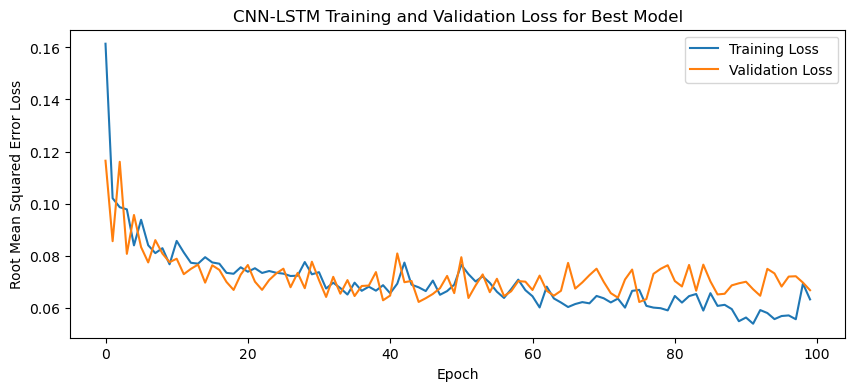

1/1 - 3s - loss: 0.0681 - 3s/epoch - 3s/step
Test Loss: 0.06810823827981949
Fold 2:
Epoch 1/100
19/19 [==============================] - 22s 402ms/step - loss: 0.1851 - val_loss: 0.0772
Epoch 2/100
19/19 [==============================] - 2s 123ms/step - loss: 0.1047 - val_loss: 0.0970
Epoch 3/100
19/19 [==============================] - 2s 119ms/step - loss: 0.0906 - val_loss: 0.0953
Epoch 4/100
19/19 [==============================] - 3s 138ms/step - loss: 0.0995 - val_loss: 0.0928
Epoch 5/100
19/19 [==============================] - 3s 133ms/step - loss: 0.0918 - val_loss: 0.0859
Epoch 6/100
19/19 [==============================] - 2s 112ms/step - loss: 0.0901 - val_loss: 0.0828
Epoch 7/100
19/19 [==============================] - 2s 116ms/step - loss: 0.0904 - val_loss: 0.0795
Epoch 8/100
19/19 [==============================] - 2s 127ms/step - loss: 0.0869 - val_loss: 0.0730
Epoch 9/100
19/19 [==============================] - 4s 193ms/step - loss: 0.0890 - val_loss: 0.0837
Epoch 

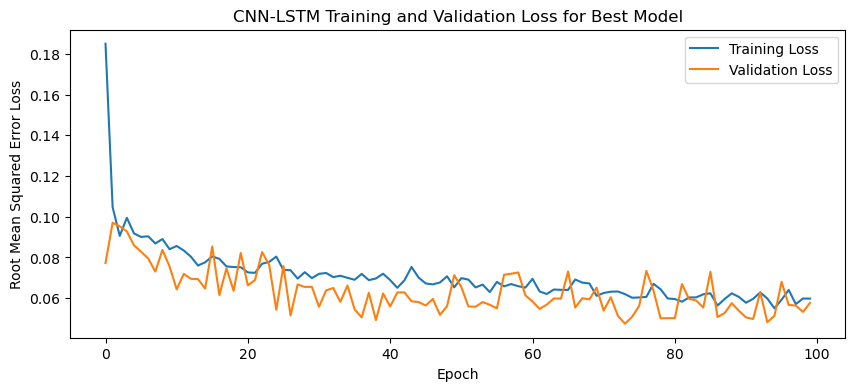

1/1 - 3s - loss: 0.1030 - 3s/epoch - 3s/step
Test Loss: 0.10297746956348419
Fold 3:
Epoch 1/100
19/19 [==============================] - 18s 346ms/step - loss: 0.1659 - val_loss: 0.0993
Epoch 2/100
19/19 [==============================] - 2s 119ms/step - loss: 0.1087 - val_loss: 0.1351
Epoch 3/100
19/19 [==============================] - 4s 187ms/step - loss: 0.1056 - val_loss: 0.1098
Epoch 4/100
19/19 [==============================] - 3s 169ms/step - loss: 0.0957 - val_loss: 0.0719
Epoch 5/100
19/19 [==============================] - 4s 208ms/step - loss: 0.0885 - val_loss: 0.0828
Epoch 6/100
19/19 [==============================] - 3s 176ms/step - loss: 0.0826 - val_loss: 0.0775
Epoch 7/100
19/19 [==============================] - 3s 167ms/step - loss: 0.0863 - val_loss: 0.0832
Epoch 8/100
19/19 [==============================] - 3s 176ms/step - loss: 0.0887 - val_loss: 0.0891
Epoch 9/100
19/19 [==============================] - 4s 196ms/step - loss: 0.0818 - val_loss: 0.0710
Epoch 

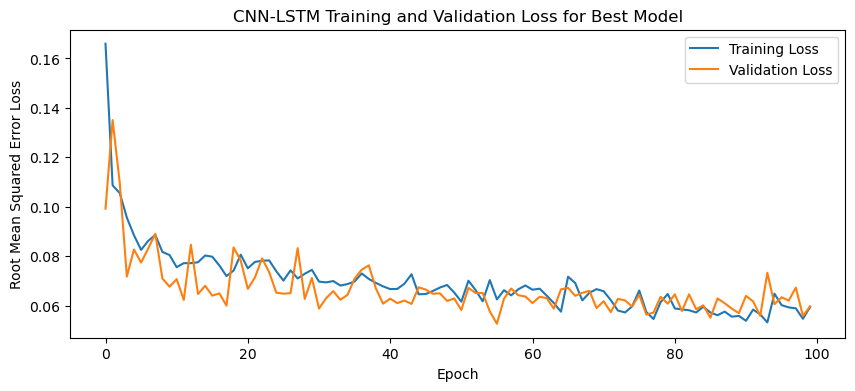

1/1 - 6s - loss: 0.0734 - 6s/epoch - 6s/step
Test Loss: 0.07338610291481018
Fold 4:
Epoch 1/100
20/20 [==============================] - 25s 356ms/step - loss: 0.2623 - val_loss: 0.1659
Epoch 2/100
20/20 [==============================] - 5s 242ms/step - loss: 0.1537 - val_loss: 0.0913
Epoch 3/100
20/20 [==============================] - 3s 160ms/step - loss: 0.1302 - val_loss: 0.1112
Epoch 4/100
20/20 [==============================] - 3s 173ms/step - loss: 0.1241 - val_loss: 0.0753
Epoch 5/100
20/20 [==============================] - 3s 154ms/step - loss: 0.1185 - val_loss: 0.1072
Epoch 6/100
20/20 [==============================] - 4s 189ms/step - loss: 0.1270 - val_loss: 0.1053
Epoch 7/100
20/20 [==============================] - 3s 171ms/step - loss: 0.1264 - val_loss: 0.0979
Epoch 8/100
20/20 [==============================] - 5s 236ms/step - loss: 0.1249 - val_loss: 0.0896
Epoch 9/100
20/20 [==============================] - 3s 158ms/step - loss: 0.1181 - val_loss: 0.0798
Epoch 

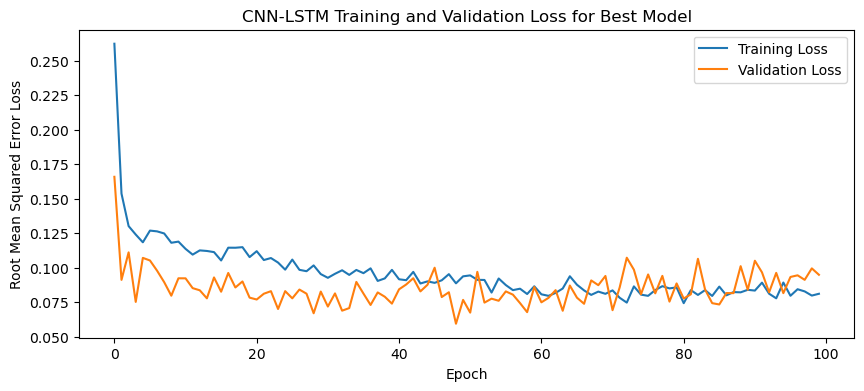

1/1 - 3s - loss: 0.0836 - 3s/epoch - 3s/step
Test Loss: 0.08360321819782257
Fold 5:
Epoch 1/100
19/19 [==============================] - 19s 480ms/step - loss: 0.1765 - val_loss: 0.1135
Epoch 2/100
19/19 [==============================] - 3s 149ms/step - loss: 0.1104 - val_loss: 0.1388
Epoch 3/100
19/19 [==============================] - 4s 206ms/step - loss: 0.1096 - val_loss: 0.0989
Epoch 4/100
19/19 [==============================] - 3s 173ms/step - loss: 0.0972 - val_loss: 0.1113
Epoch 5/100
19/19 [==============================] - 4s 213ms/step - loss: 0.0874 - val_loss: 0.0959
Epoch 6/100
19/19 [==============================] - 4s 197ms/step - loss: 0.0899 - val_loss: 0.0812
Epoch 7/100
19/19 [==============================] - 4s 204ms/step - loss: 0.0865 - val_loss: 0.1031
Epoch 8/100
19/19 [==============================] - 4s 209ms/step - loss: 0.0817 - val_loss: 0.0991
Epoch 9/100
19/19 [==============================] - 3s 172ms/step - loss: 0.0773 - val_loss: 0.0854
Epoch 

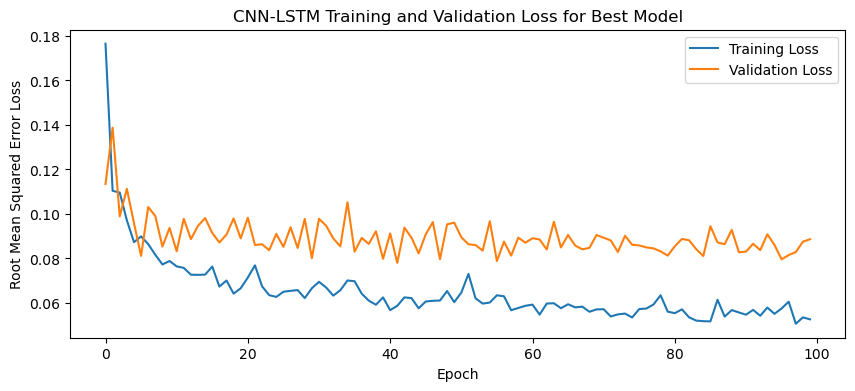

1/1 - 8s - loss: 0.0711 - 8s/epoch - 8s/step
Test Loss: 0.07109112292528152


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

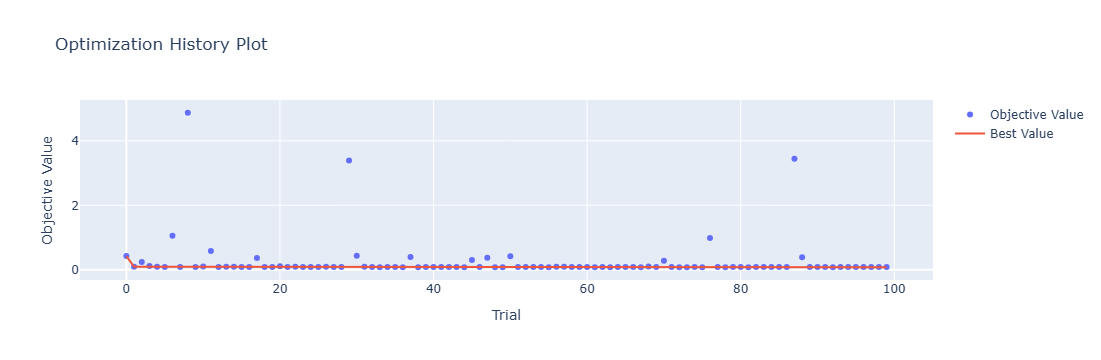

In [4]:
optuna.visualization.plot_optimization_history(study)

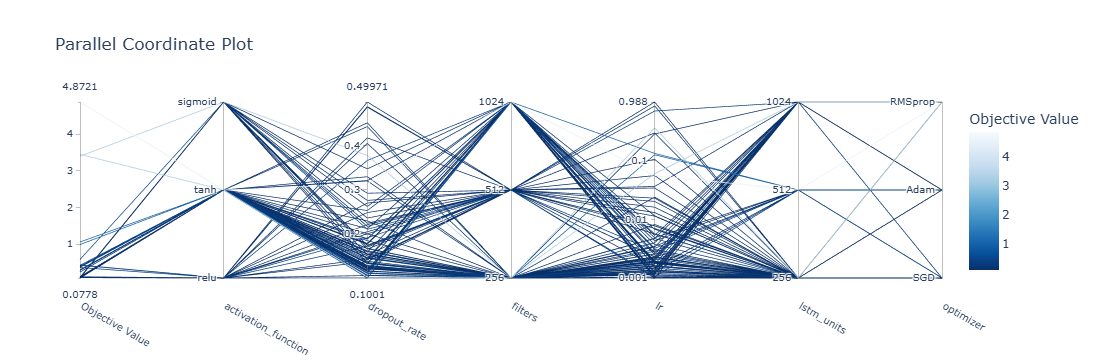

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

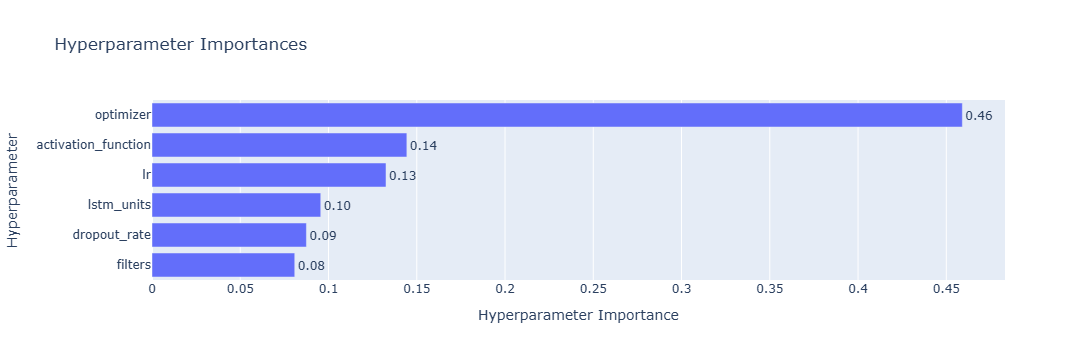

In [6]:
optuna.visualization.plot_param_importances(study)

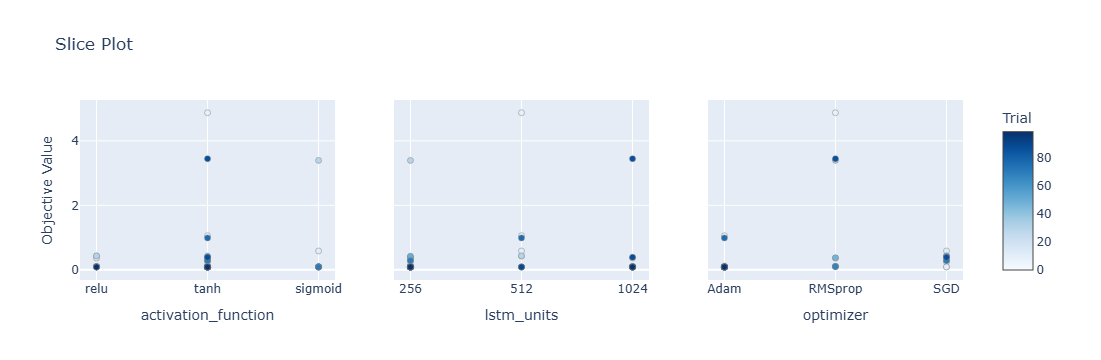

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

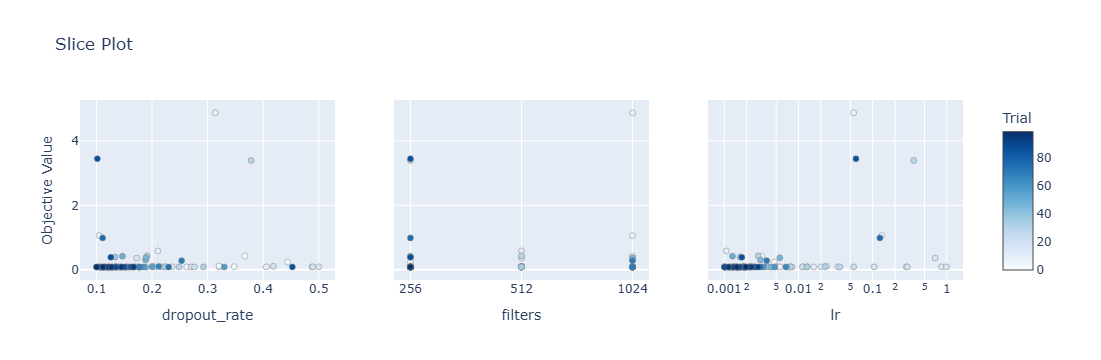

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 27s 351ms/step - loss: 0.1675 - accuracy: 0.1053 - mae: 0.1463 - rmse: 0.1675 - mape: 34.9603 - pearson: 0.2034 - val_loss: 0.0928 - val_accuracy: 0.0000e+00 - val_mae: 0.0720 - val_rmse: 0.0928 - val_mape: 16.9263 - val_pearson: 0.1513
Epoch 2/100
19/19 [==============================] - 2s 81ms/step - loss: 0.0976 - accuracy: 0.3158 - mae: 0.0815 - rmse: 0.0976 - mape: 20.1597 - pearson: 0.2345 - val_loss: 0.0925 - val_accuracy: 0.3333 - val_mae: 0.0750 - val_rmse: 0.0925 - val_mape: 18.2408 - val_pearson: 0.2034
Epoch 3/100
19/19 [==============================] - 2s 122ms/step - loss: 0.0938 - acc

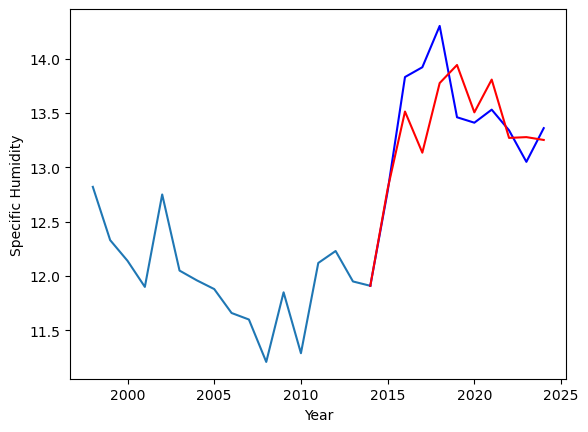

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		10.02		0.31
10.79		10.71		-0.08
10.20		10.40		0.20
10.87		10.93		0.06
10.99		11.10		0.11
10.80		10.67		-0.13
11.01		10.92		-0.09
10.57		10.52		-0.05
10.05		10.47		0.42
10.24		10.47		0.23


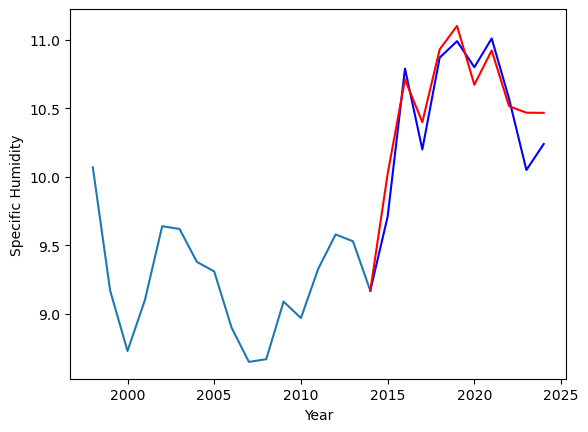

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.801032
1                1    9.71  10.022310


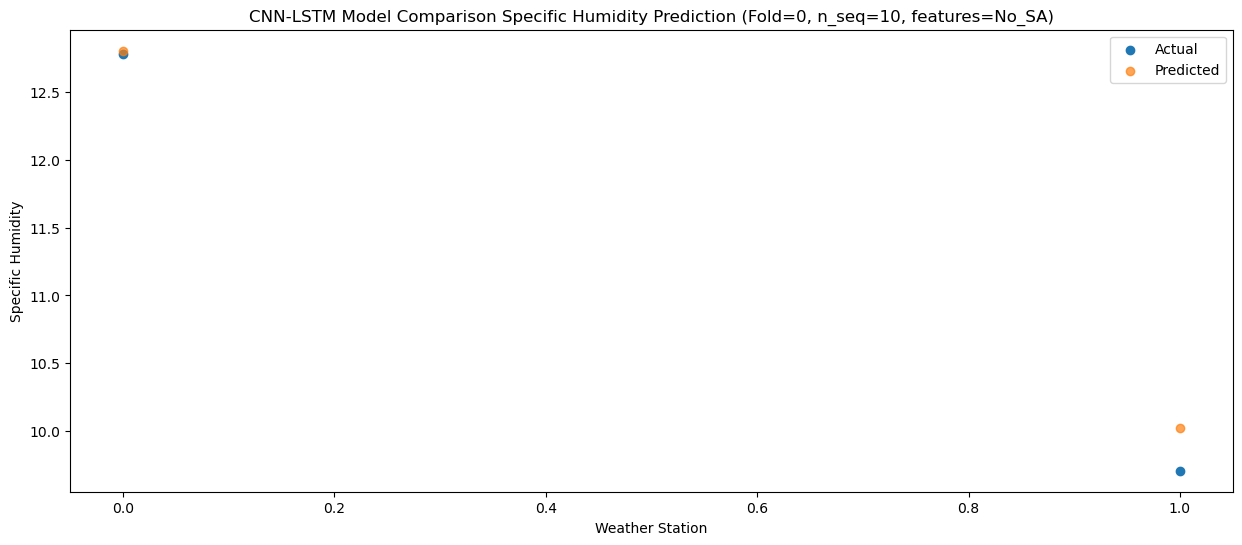

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.512580
1                1   10.79  10.710508


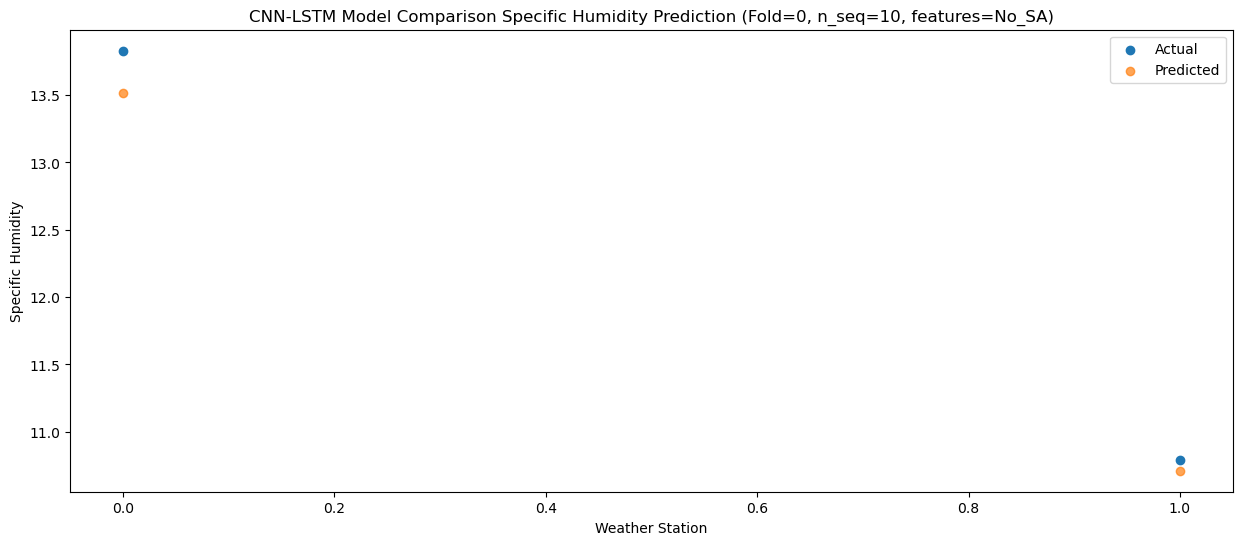

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  13.134361
1                1   10.20  10.399327


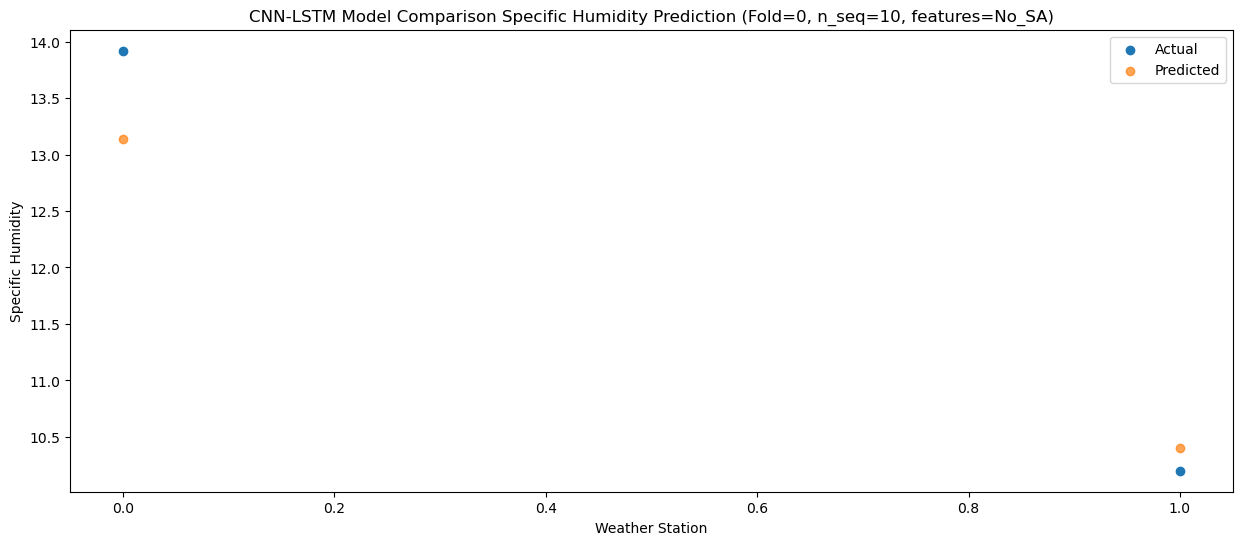

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.774478
1                1   10.87  10.930134


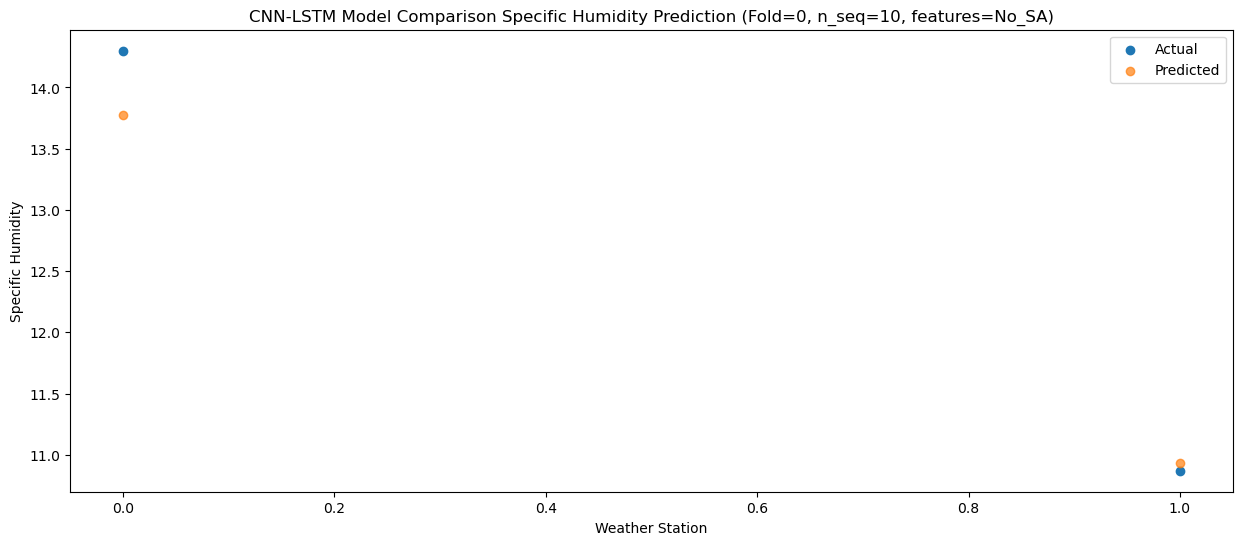

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.940725
1                1   10.99  11.101413


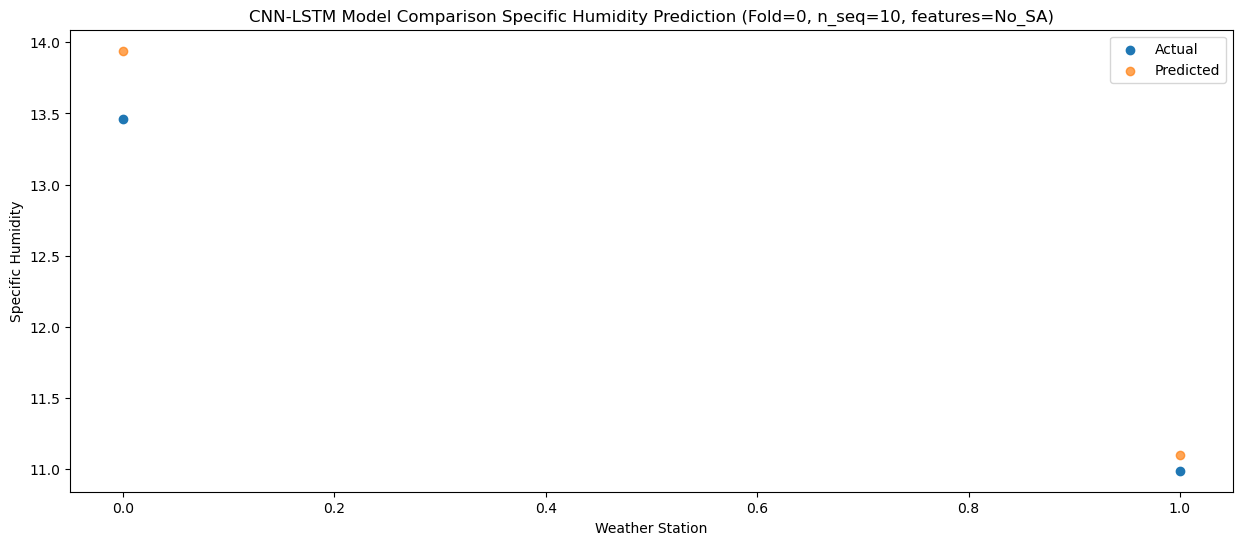

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  13.505079
1                1   10.80  10.672310


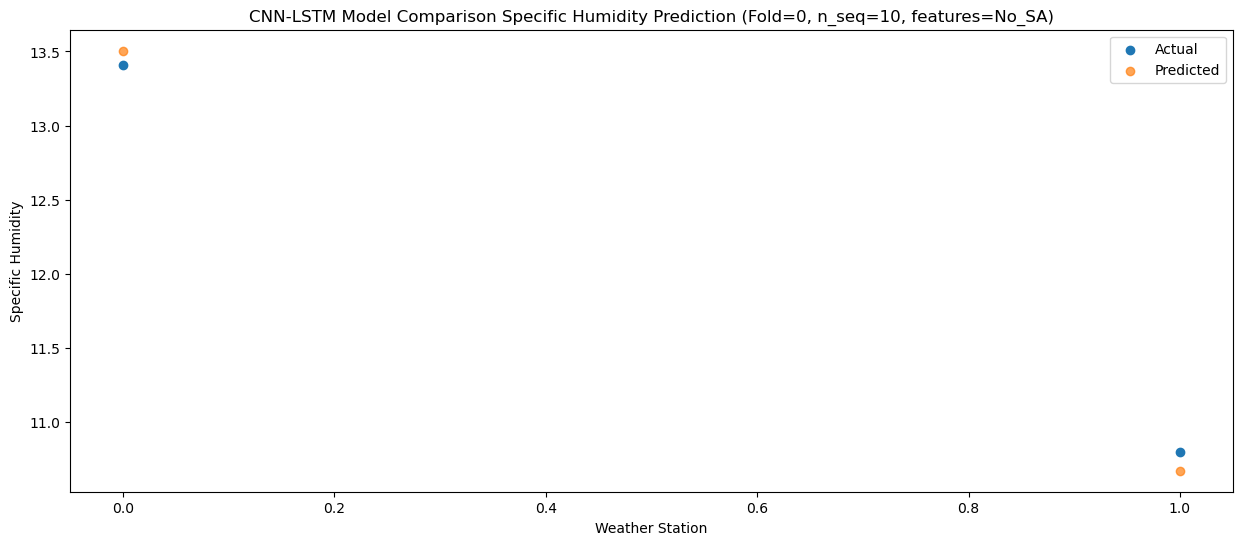

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  13.806471
1                1   11.01  10.922341


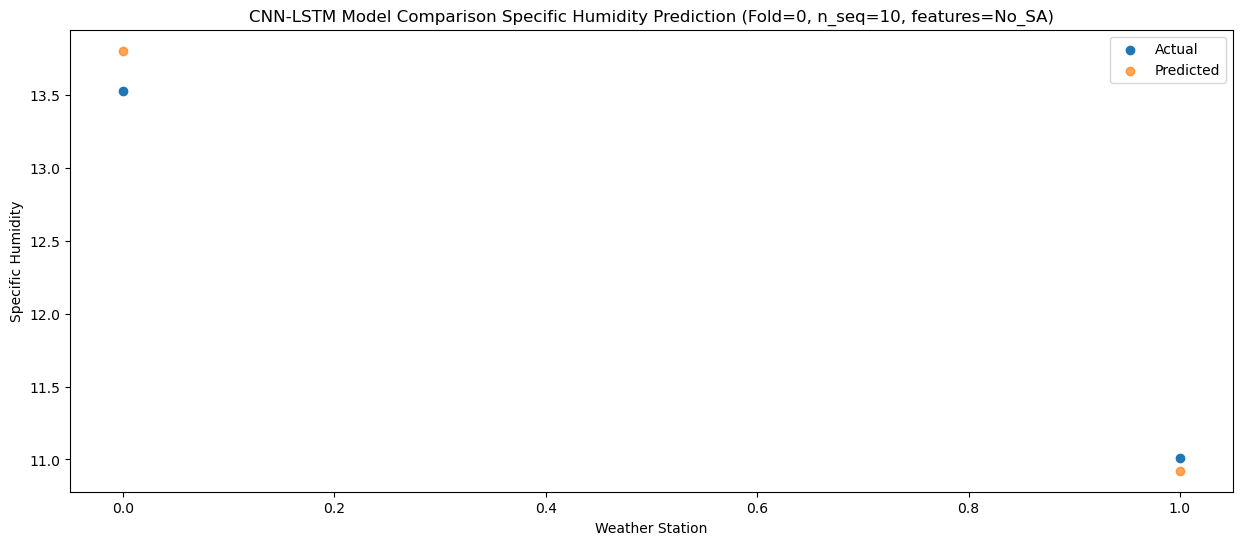

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.270107
1                1   10.57  10.515664


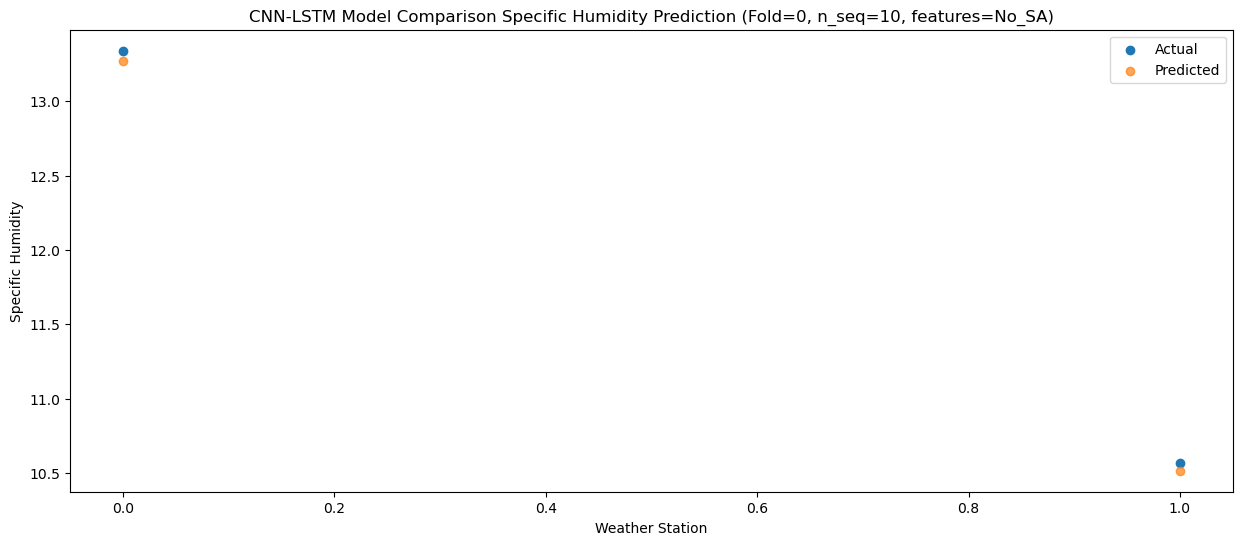

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  13.277351
1                1   10.05  10.468328


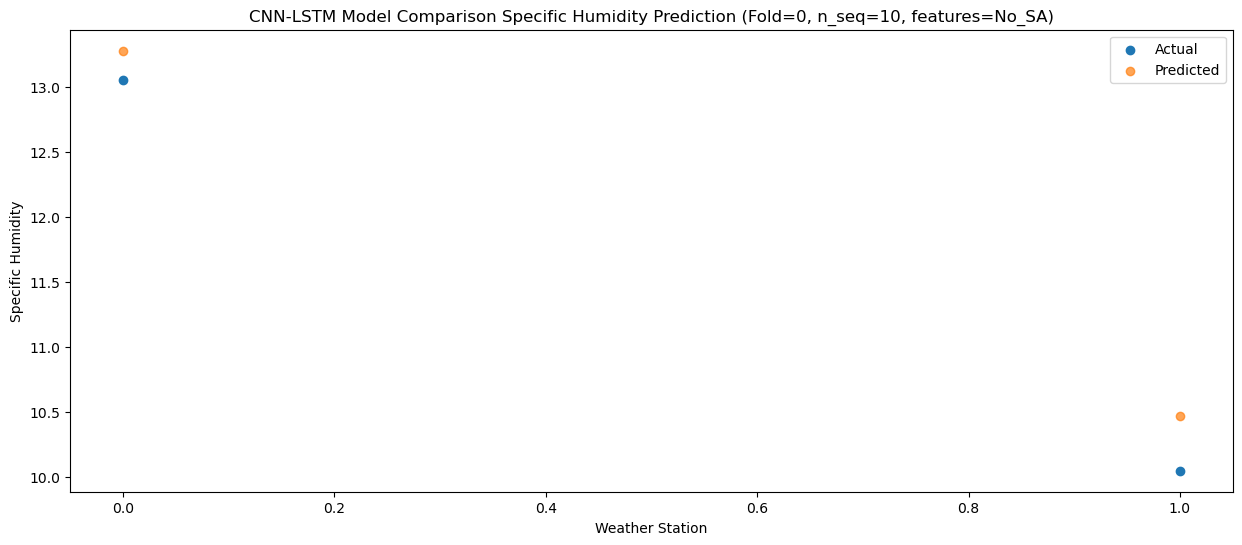

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  13.251315
1                1   10.24  10.467230


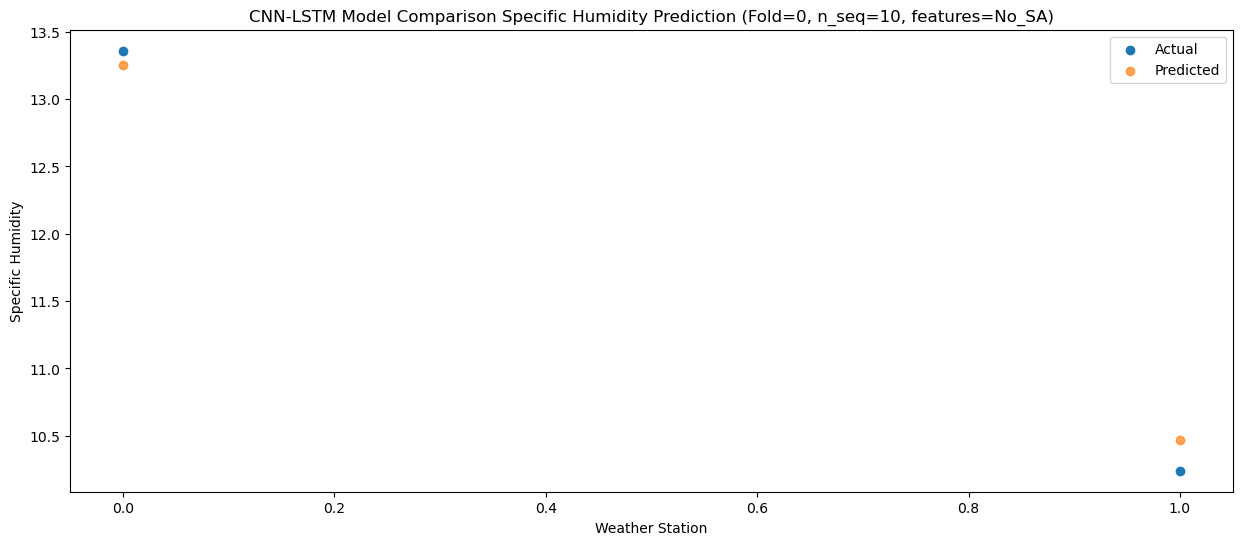

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.80103187 10.02231011]
 [13.51257978 10.71050802]
 [13.13436063 10.39932716]
 [13.77447762 10.93013436]
 [13.94072542 11.10141325]
 [13.50507906 10.67231017]
 [13.80647102 10.92234102]
 [13.27010658 10.51566383]
 [13.27735137 10.46832841]
 [13.25131514 10.46722999]]
Year at t+1:
t+1 SKRMSE: 0.221337
t+1 KRMSE: 0.221337
t+1 MAE: 0.166671
t+1 SKMAPE: 0.016905
t+1 R2_SCORE: 0.979208
t+1 KMAPE: 0.016905
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.231381
t+2 KRMSE: 0.231381
t+2 MAE: 0.198456
t+2 SKMAPE: 0.015159
t+2 R2_SCORE: 0.976828
t+2 KMAPE: 0.015159
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.573132
t+3 KRMSE: 0.573132
t+3 MAE: 0.492483
t+3 SKMAPE: 0.037991
t+3 R2_SCORE: 0.905053
t+3 KMAPE: 0.037991
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

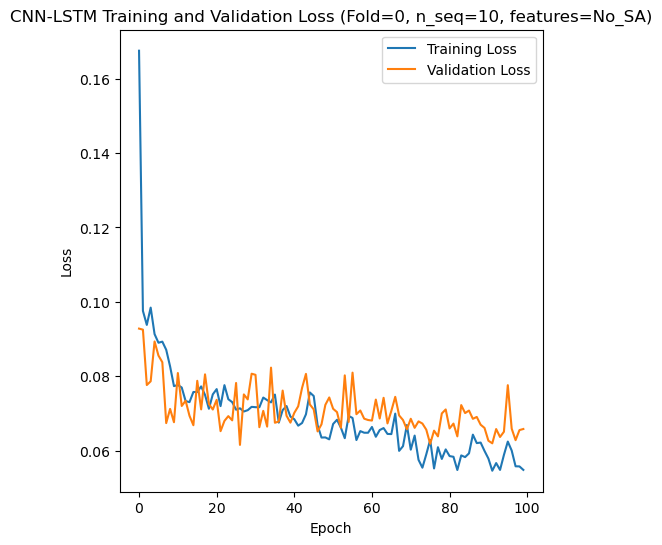

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 35s 553ms/step - loss: 0.1660 - accuracy: 0.2632 - mae: 0.1455 - rmse: 0.1660 - mape: 33.6186 - pearson: 0.2083 - val_loss: 0.0999 - val_accuracy: 0.3333 - val_mae: 0.0770 - val_rmse: 0.0999 - val_mape: 20.1070 - val_pearson: 0.2527
Epoch 2/100
19/19 [==============================] - 3s 182ms/step - loss: 0.1056 - accuracy: 0.2632 - mae: 0.0877 - rmse: 0.1056 - mape: 20.7089 - pearson: 0.2325 - val_loss: 0.0857 - val_accuracy: 0.6667 - val_mae: 0.0729 - val_rmse: 0.0857 - val_mape: 17.3620 - val_pearson: 0.3931
Epoch 3/100
19/19 [==============================] - 3s 180ms/step - loss: 0.1039 - accura

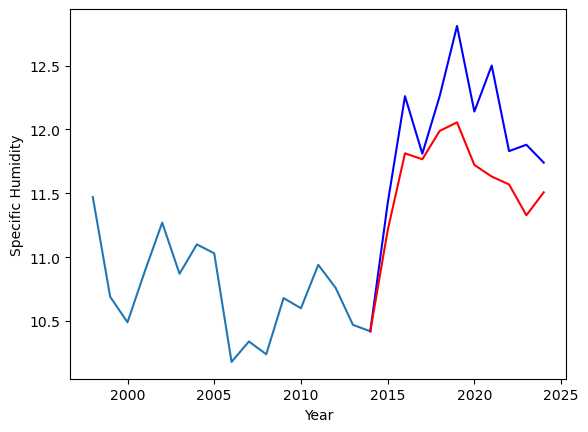

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.63		-0.32
9.08		8.00		-1.08
9.06		7.94		-1.12
8.69		8.08		-0.61
8.53		8.04		-0.49
8.56		7.78		-0.78
7.82		7.74		-0.08
8.26		7.68		-0.58
7.69		7.54		-0.15
7.84		7.75		-0.09


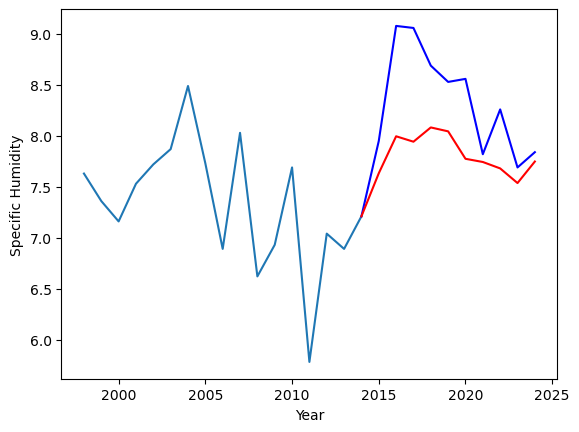

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.208830
1                1    7.95   7.632784


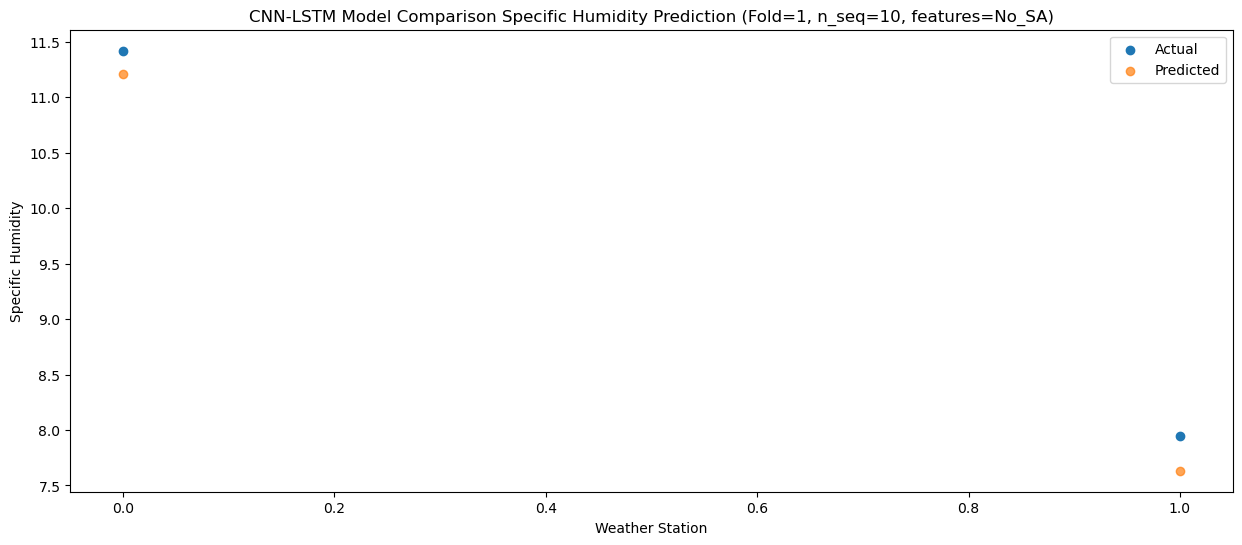

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.812608
1                1    9.08   7.996102


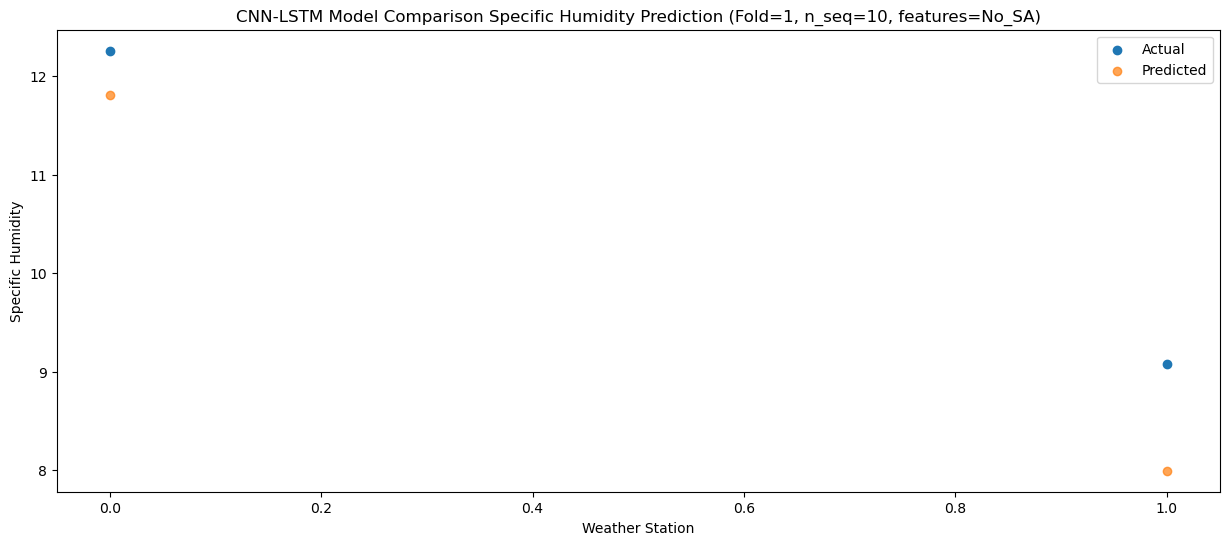

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  11.766408
1                1    9.06   7.942831


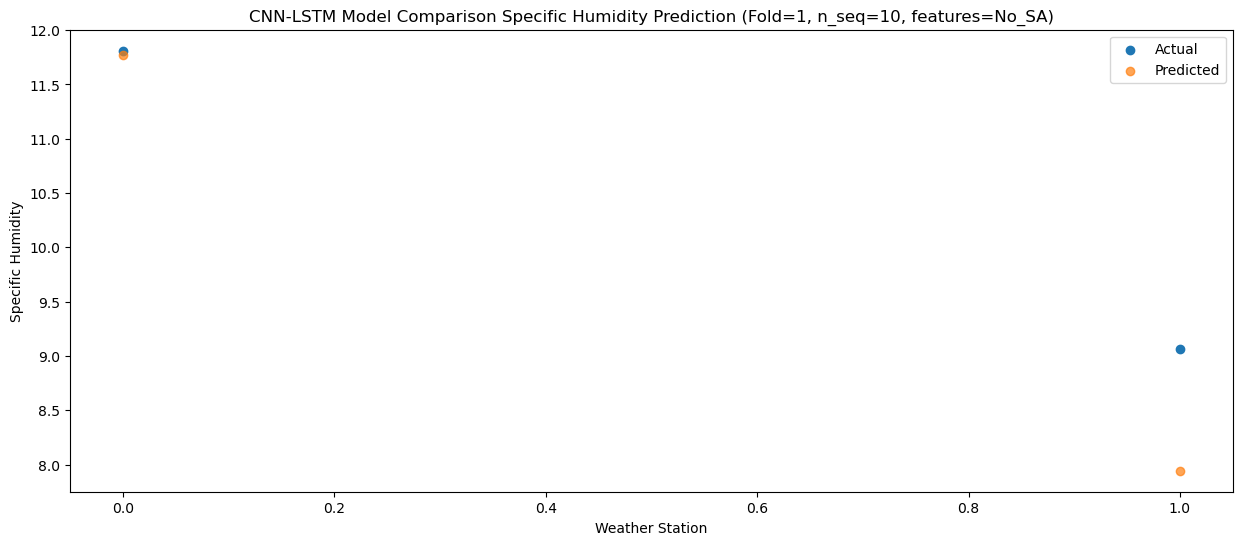

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  11.988306
1                1    8.69   8.082976


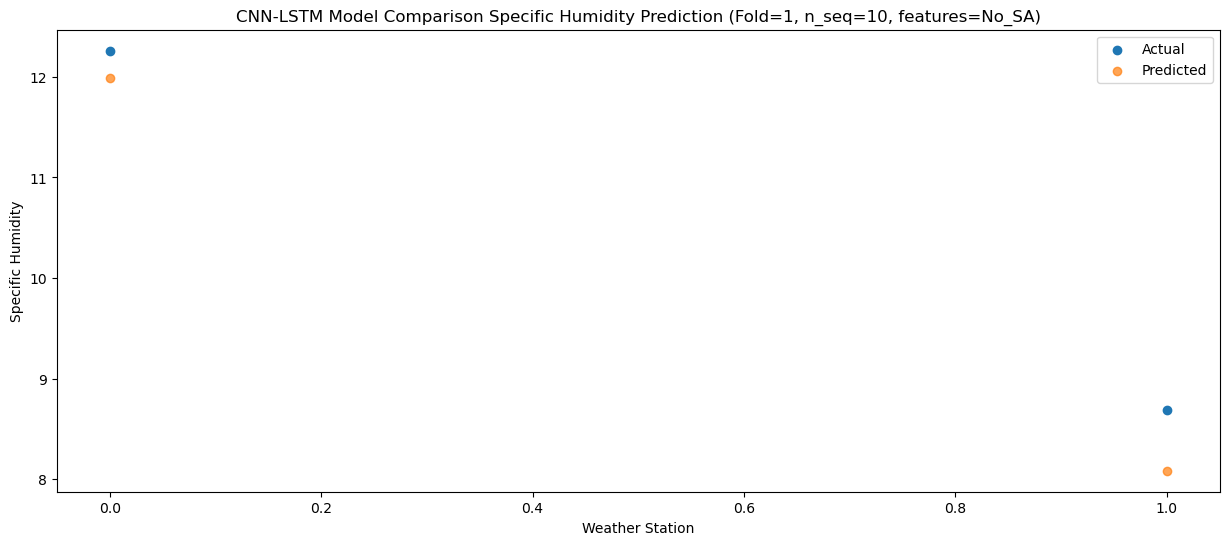

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.055110
1                1    8.53   8.044505


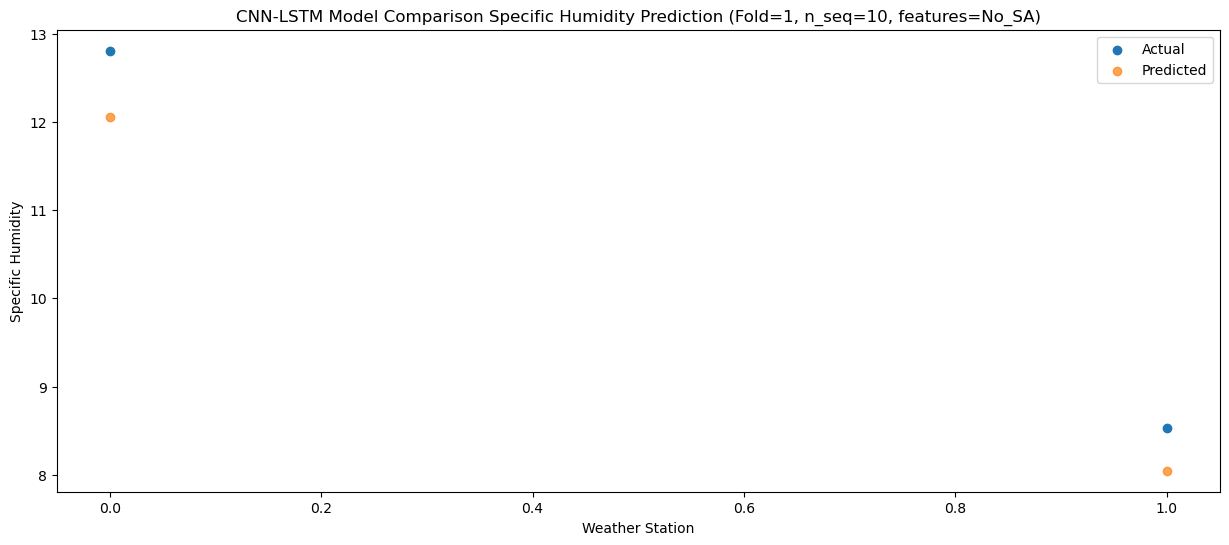

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.721976
1                1    8.56   7.775006


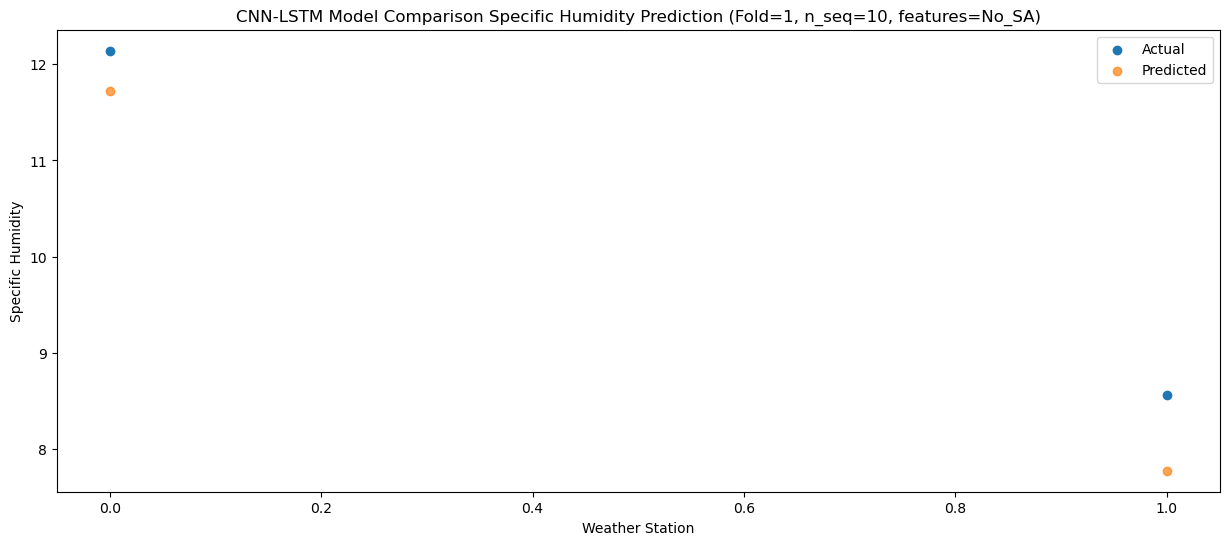

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.630980
1                1    7.82   7.743619


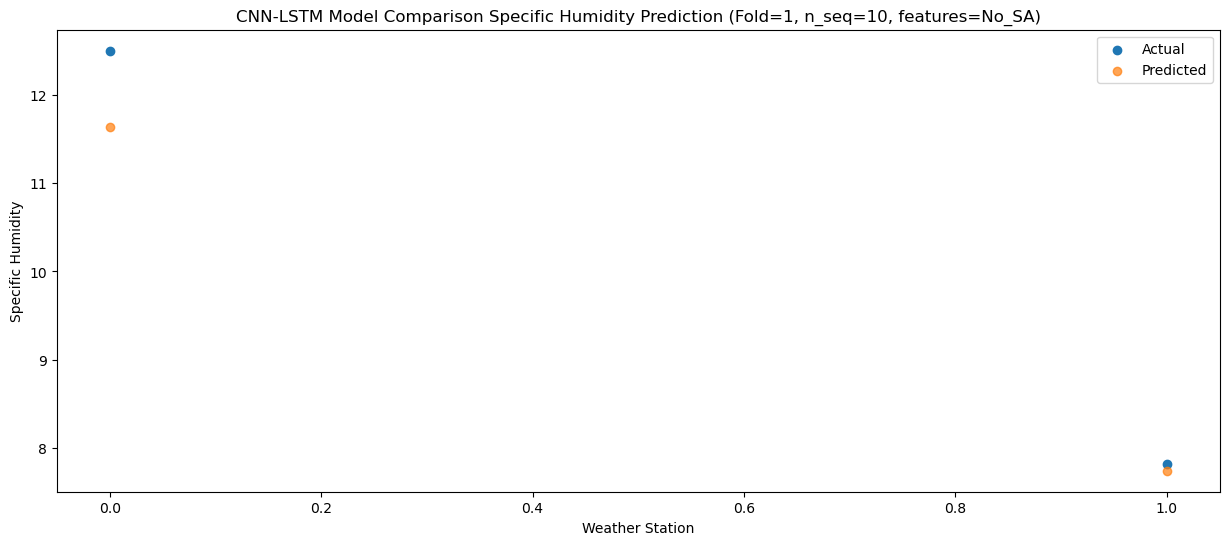

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.569230
1                1    8.26   7.680507


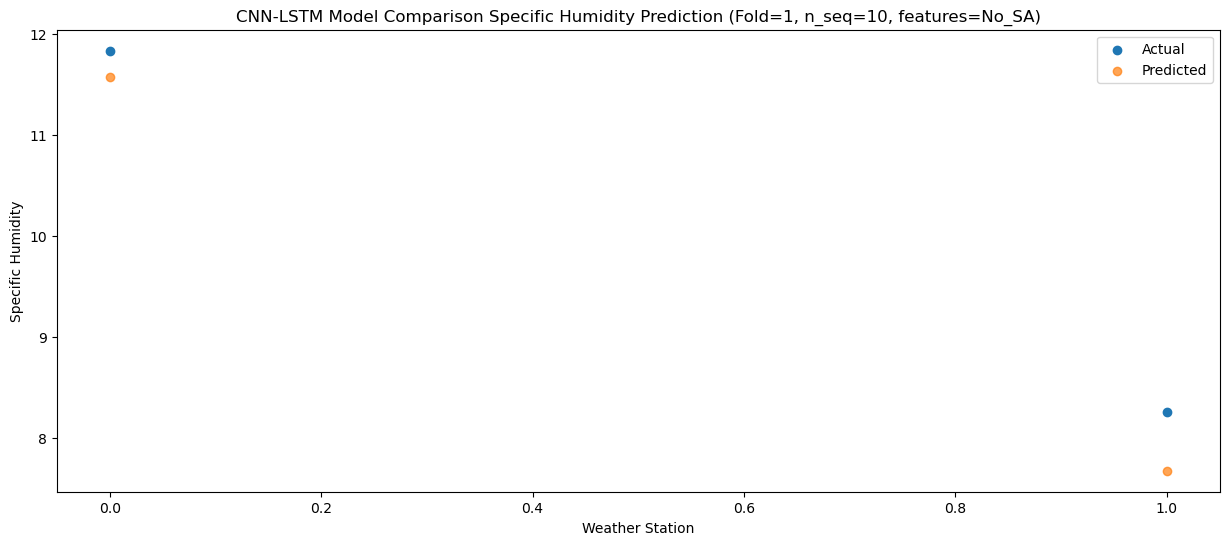

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.327928
1                1    7.69   7.536729


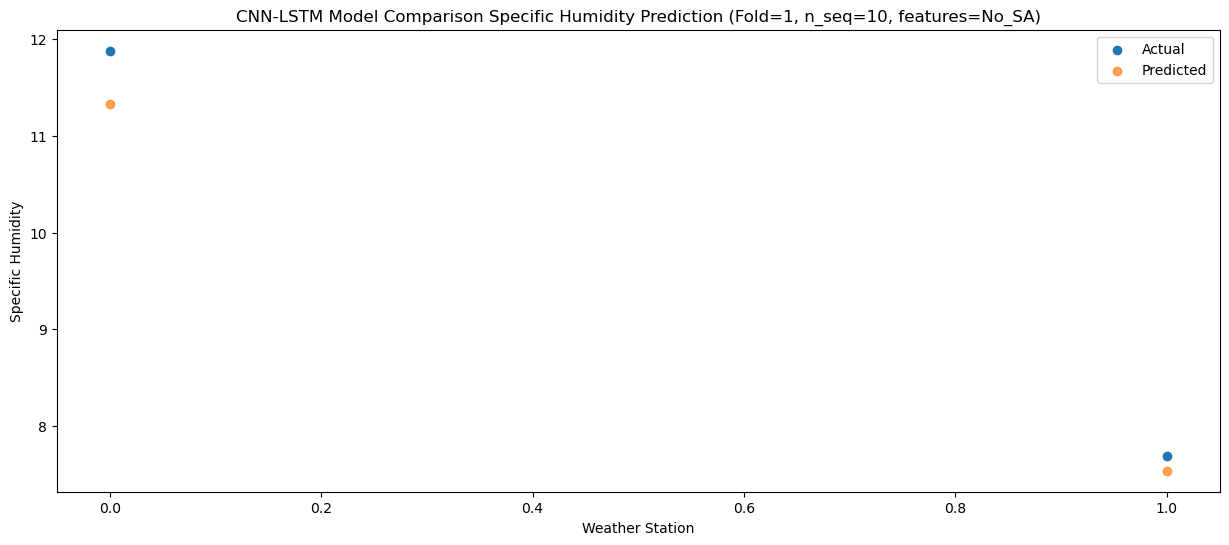

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.507506
1                1    7.84   7.748185


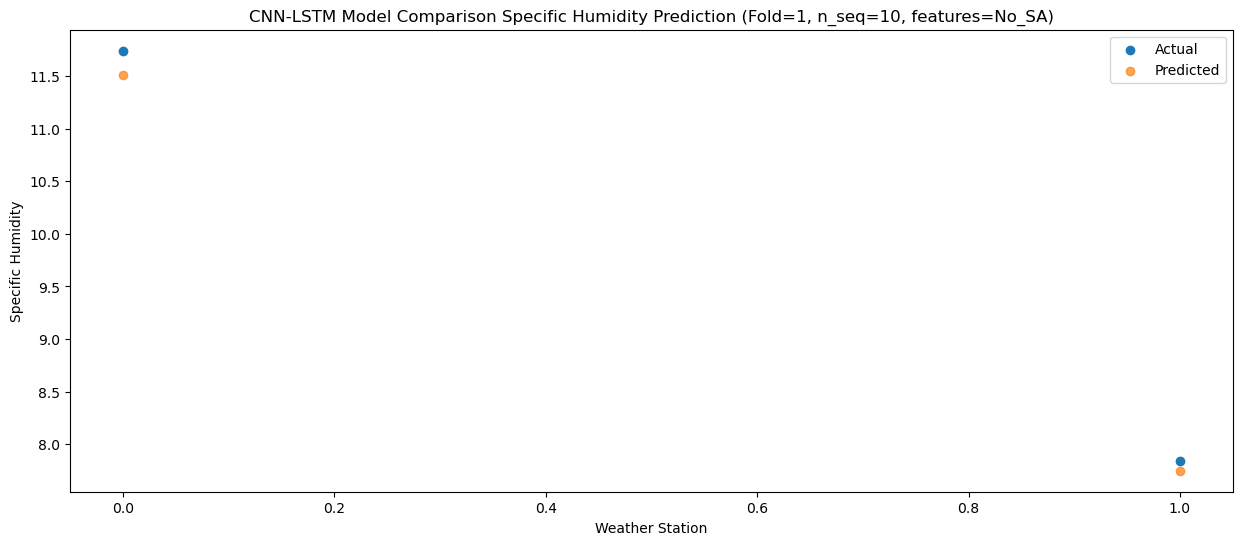

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.20882958  7.63278361]
 [11.81260818  7.99610232]
 [11.76640757  7.94283131]
 [11.98830635  8.08297623]
 [12.05510975  8.0445055 ]
 [11.72197626  7.77500551]
 [11.63097975  7.74361886]
 [11.56922992  7.68050685]
 [11.3279281   7.53672903]
 [11.50750637  7.74818478]]
Year at t+1:
t+1 SKRMSE: 0.269462
t+1 KRMSE: 0.269462
t+1 MAE: 0.264193
t+1 SKMAPE: 0.029196
t+1 R2_SCORE: 0.975879
t+1 KMAPE: 0.029196
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.829154
t+2 KRMSE: 0.829154
t+2 MAE: 0.765645
t+2 SKMAPE: 0.077932
t+2 R2_SCORE: 0.728058
t+2 KMAPE: 0.077932
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.790559
t+3 KRMSE: 0.790559
t+3 MAE: 0.580381
t+3 SKMAPE: 0.063499
t+3 R2_SCORE: 0.669430
t+3 KMAPE: 0.063499
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

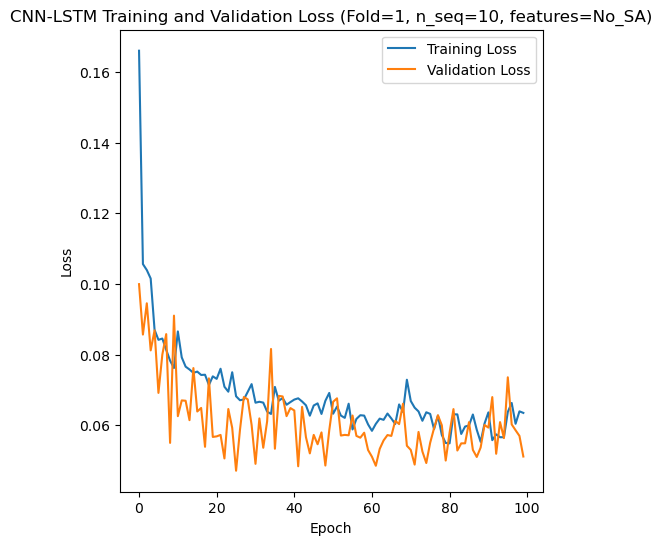

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 31s 507ms/step - loss: 0.1636 - accuracy: 0.1053 - mae: 0.1431 - rmse: 0.1636 - mape: 32.6005 - pearson: 0.1176 - val_loss: 0.1125 - val_accuracy: 0.0000e+00 - val_mae: 0.0928 - val_rmse: 0.1125 - val_mape: 23.2062 - val_pearson: 0.2013
Epoch 2/100
19/19 [==============================] - 4s 193ms/step - loss: 0.1093 - accuracy: 0.3158 - mae: 0.0931 - rmse: 0.1093 - mape: 21.6384 - pearson: 0.2379 - val_loss: 0.1042 - val_accuracy: 0.3333 - val_mae: 0.0852 - val_rmse: 0.1042 - val_mape: 21.0054 - val_pearson: 0.3385
Epoch 3/100
19/19 [==============================] - 3s 172ms/step - loss: 0.0931 - ac

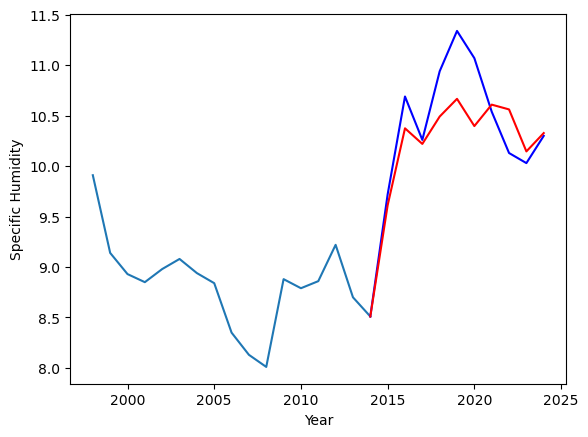

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.06		0.38
8.43		8.64		0.21
8.98		8.88		-0.10
8.93		8.60		-0.33
9.03		8.91		-0.12
8.38		8.49		0.11
8.20		8.37		0.17
8.27		8.66		0.39
8.54		8.20		-0.34
8.55		8.29		-0.26


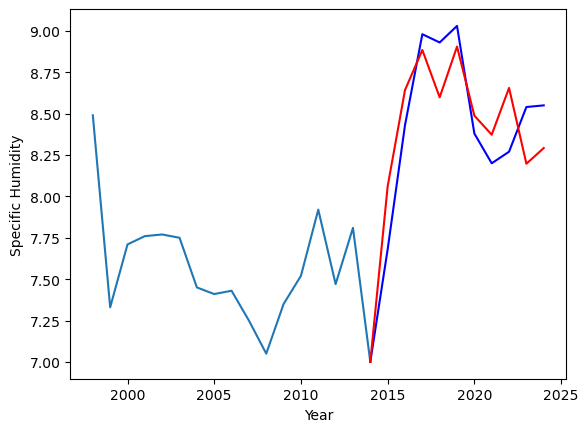

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72   9.612218
1                1    7.68   8.060737


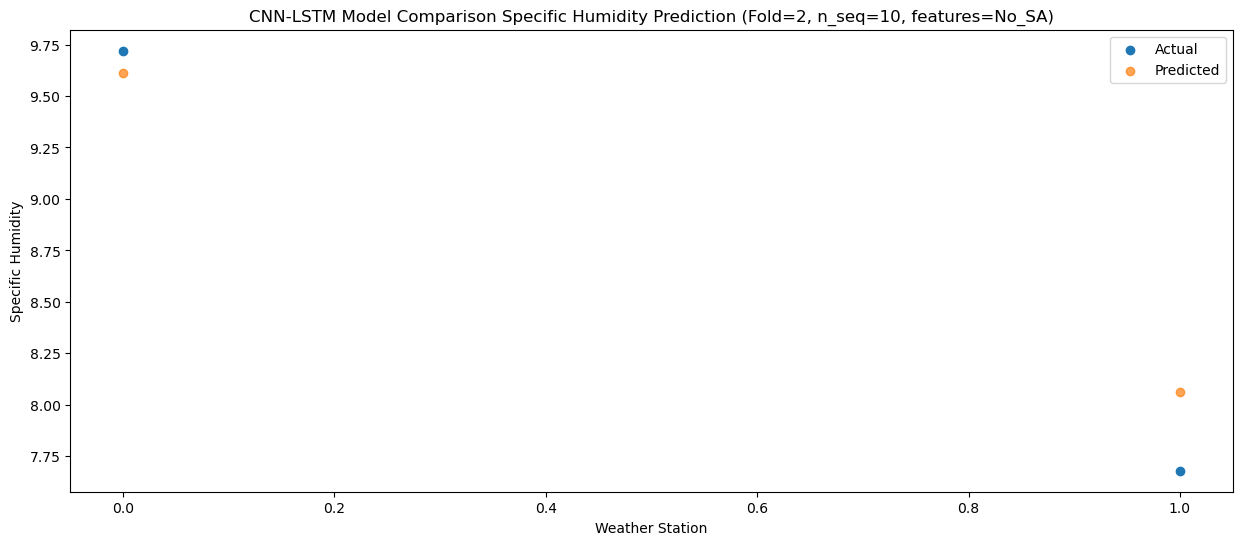

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.374754
1                1    8.43   8.642073


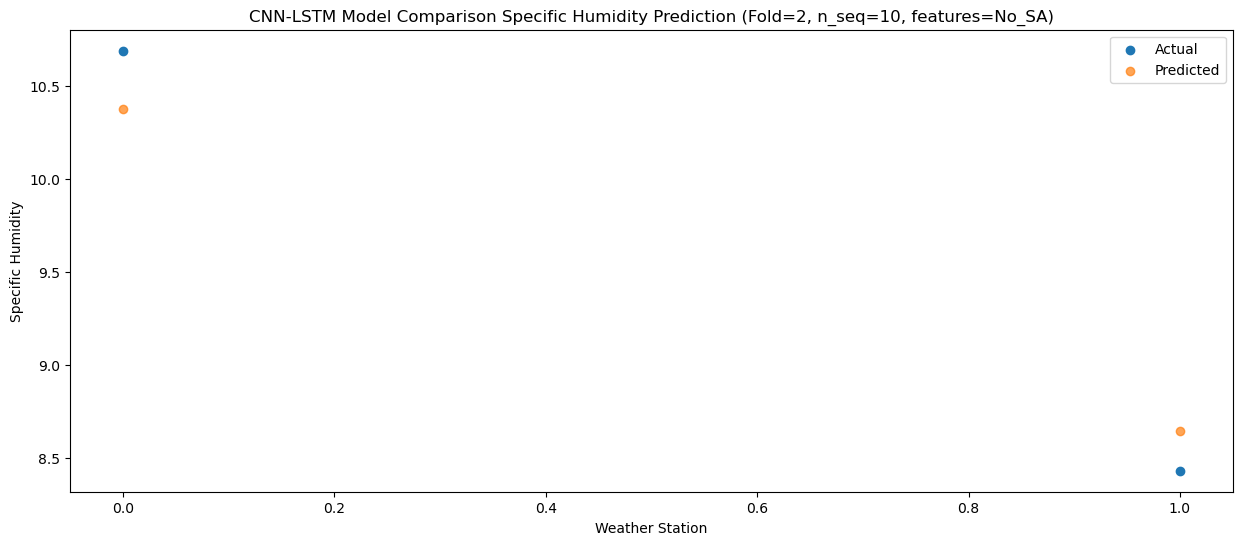

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.220125
1                1    8.98   8.884505


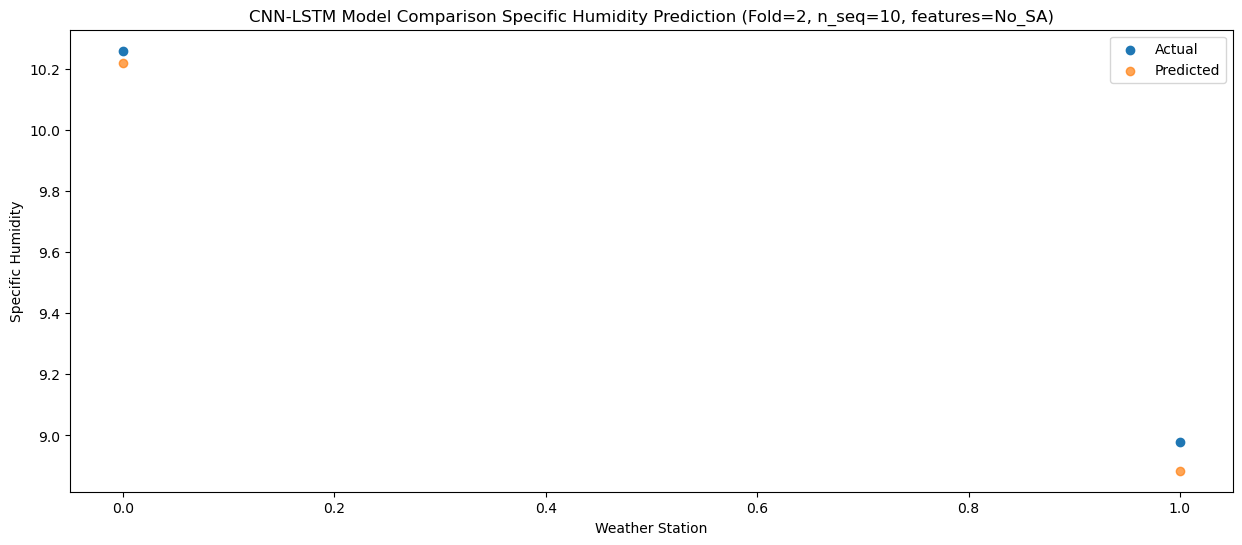

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.491361
1                1    8.93   8.598512


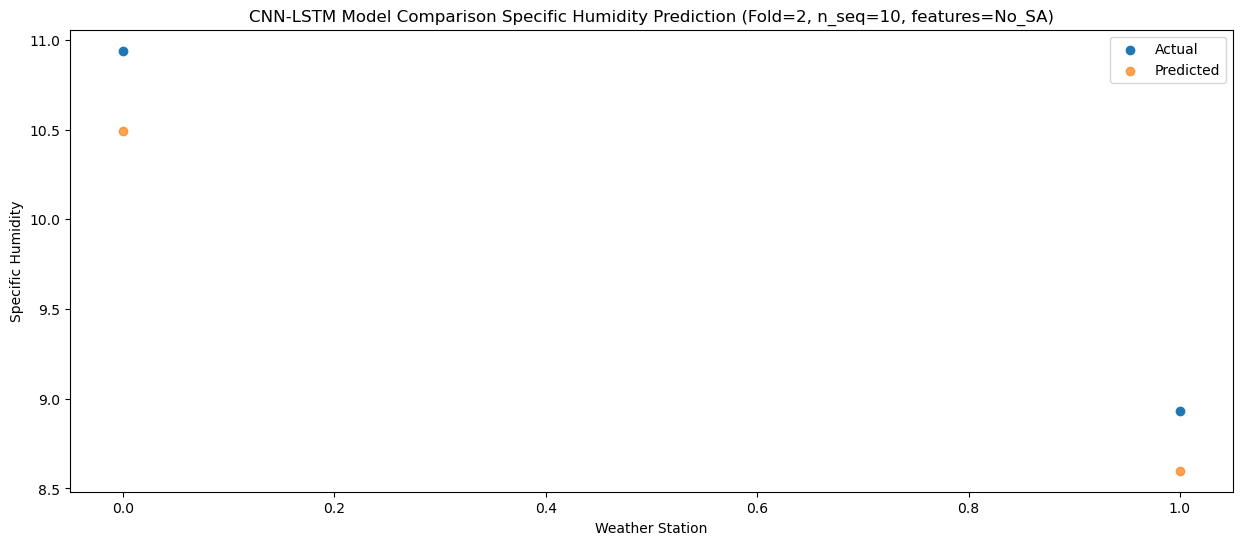

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.666949
1                1    9.03   8.905200


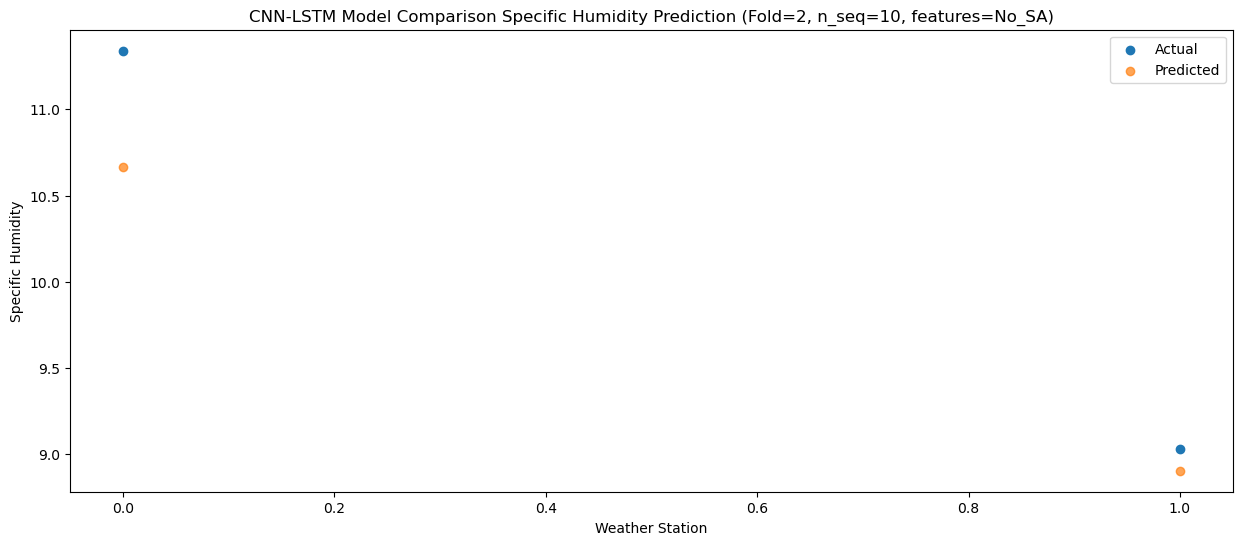

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.397041
1                1    8.38   8.487841


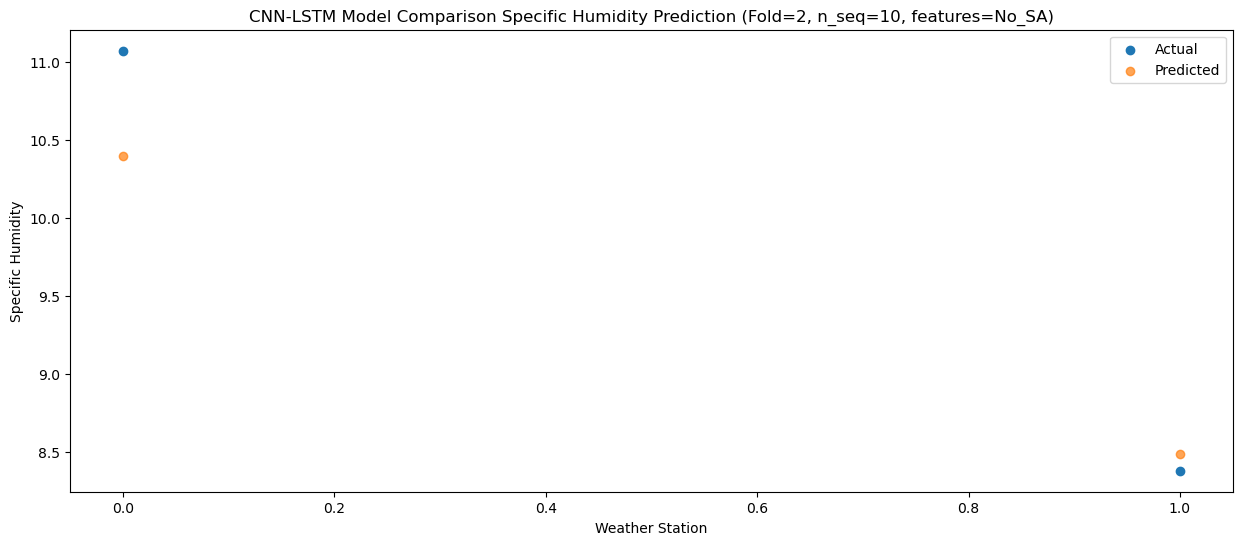

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.609376
1                1    8.20   8.372781


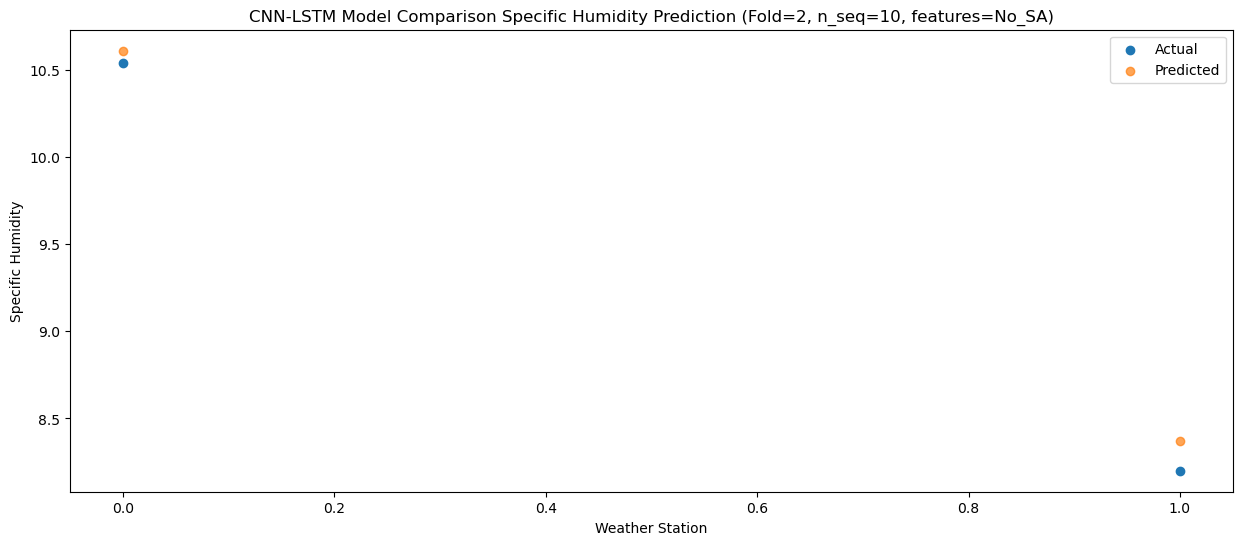

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.562024
1                1    8.27   8.655377


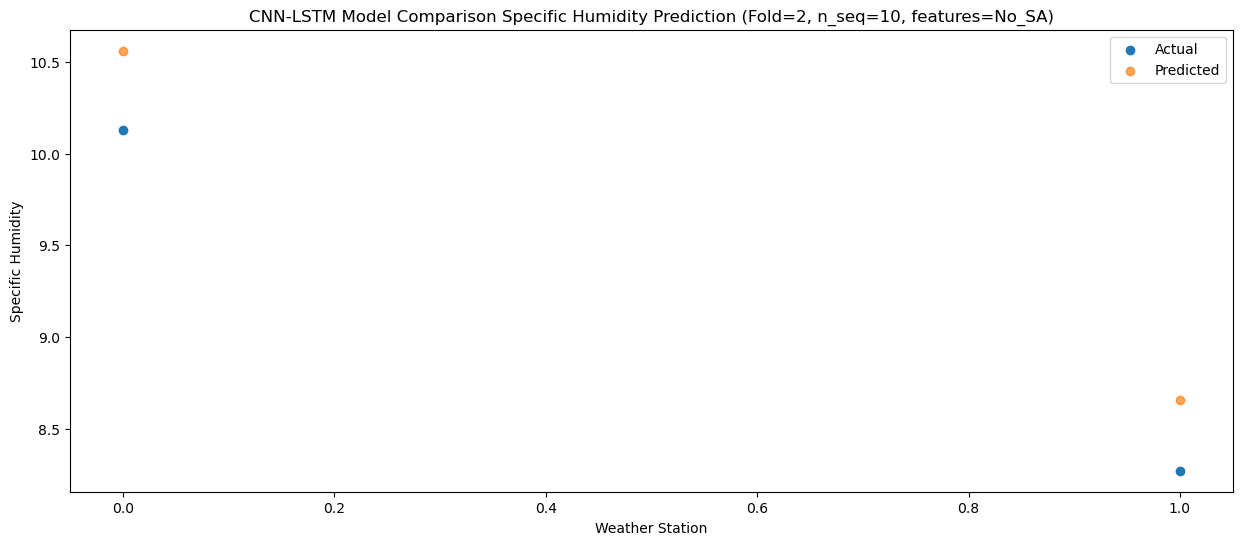

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03  10.145879
1                1    8.54   8.197438


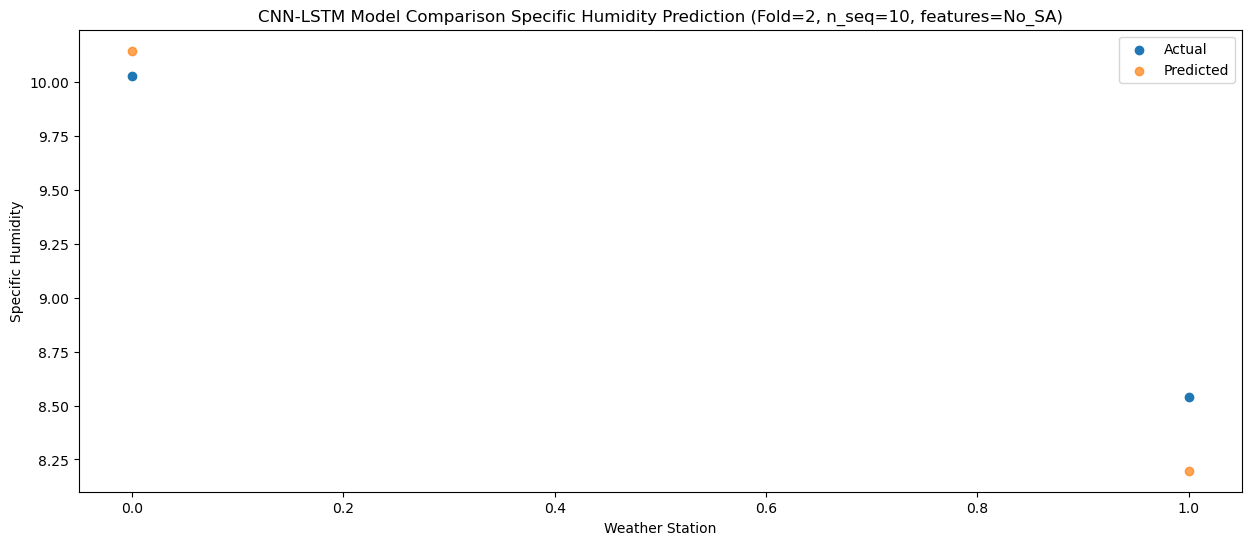

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.327644
1                1    8.55   8.291986


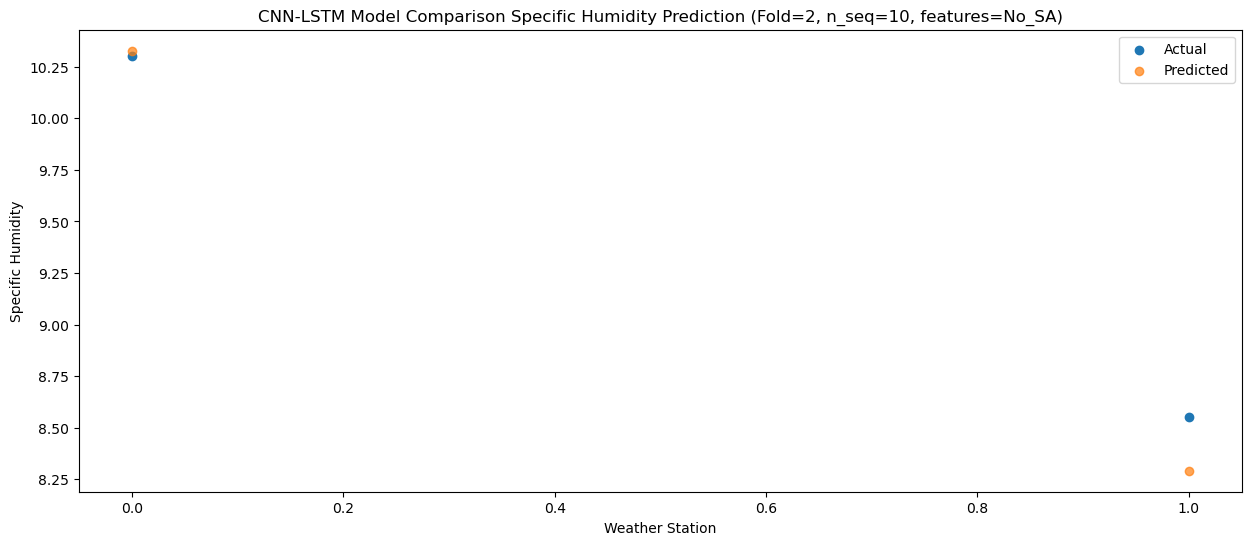

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[ 9.61221812  8.06073712]
 [10.37475363  8.64207267]
 [10.22012514  8.8845054 ]
 [10.49136079  8.59851218]
 [10.66694937  8.9052001 ]
 [10.39704064  8.48784131]
 [10.60937637  8.37278147]
 [10.56202383  8.65537651]
 [10.14587937  8.19743778]
 [10.32764401  8.2919856 ]]
Year at t+1:
t+1 SKRMSE: 0.279801
t+1 KRMSE: 0.279801
t+1 MAE: 0.244260
t+1 SKMAPE: 0.030332
t+1 R2_SCORE: 0.924751
t+1 KMAPE: 0.030332
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.268659
t+2 KRMSE: 0.268659
t+2 MAE: 0.263660
t+2 SKMAPE: 0.027323
t+2 R2_SCORE: 0.943474
t+2 KMAPE: 0.027323
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.073175
t+3 KRMSE: 0.073175
t+3 MAE: 0.067685
t+3 SKMAPE: 0.007260
t+3 R2_SCORE: 0.986927
t+3 KMAPE: 0.007260
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

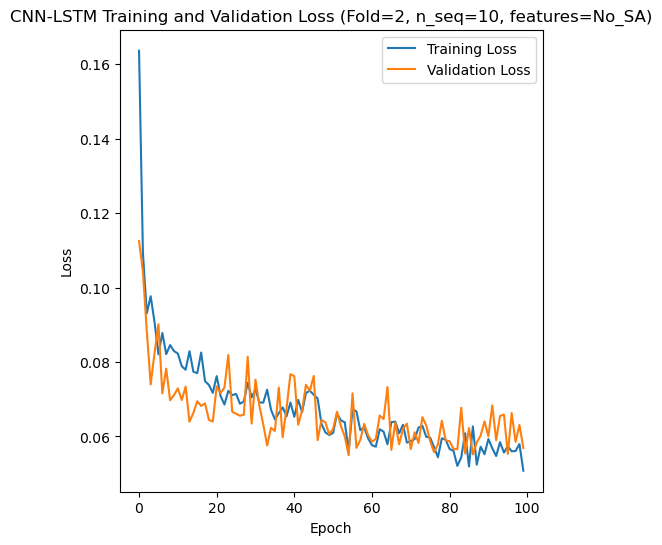

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 30s 403ms/step - loss: 0.2471 - accuracy: 0.3000 - mae: 0.2198 - rmse: 0.2471 - mape: 36.9501 - pearson: 0.1890 - val_loss: 0.1348 - val_accuracy: 0.5000 - val_mae: 0.1079 - val_rmse: 0.1348 - val_mape: 16.8713 - val_pearson: 0.1225
Epoch 2/100
20/20 [==============================] - 2s 80ms/step - loss: 0.1536 - accuracy: 0.4000 - mae: 0.1271 - rmse: 0.1536 - mape: 21.9764 - pearson: 0.1706 - val_loss: 0.1379 - val_accuracy: 0.0000e+00 - val_mae: 0.1150 - val_rmse: 0.1379 - val_mape: 19.5112 - val_pearson: 0.1144
Epoch 3/100
20/20 [==============================] - 2s 102ms/step - loss: 0.1465 - accuracy: 0.4500 - mae: 0.1193 - rmse: 0.1465 - mape: 20.6828

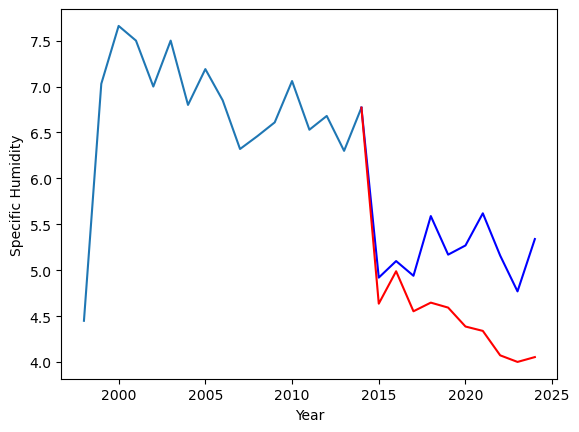

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.97		0.02
8.59		8.63		0.04
8.69		8.68		-0.01
8.51		8.72		0.21
8.87		9.09		0.22
8.75		8.66		-0.09
8.66		8.58		-0.08
8.63		8.47		-0.16
8.16		8.22		0.06
8.18		8.35		0.17


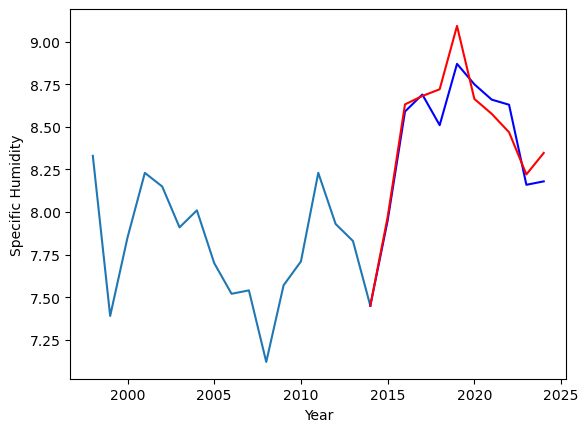

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.636310
1                1    7.95   7.970283


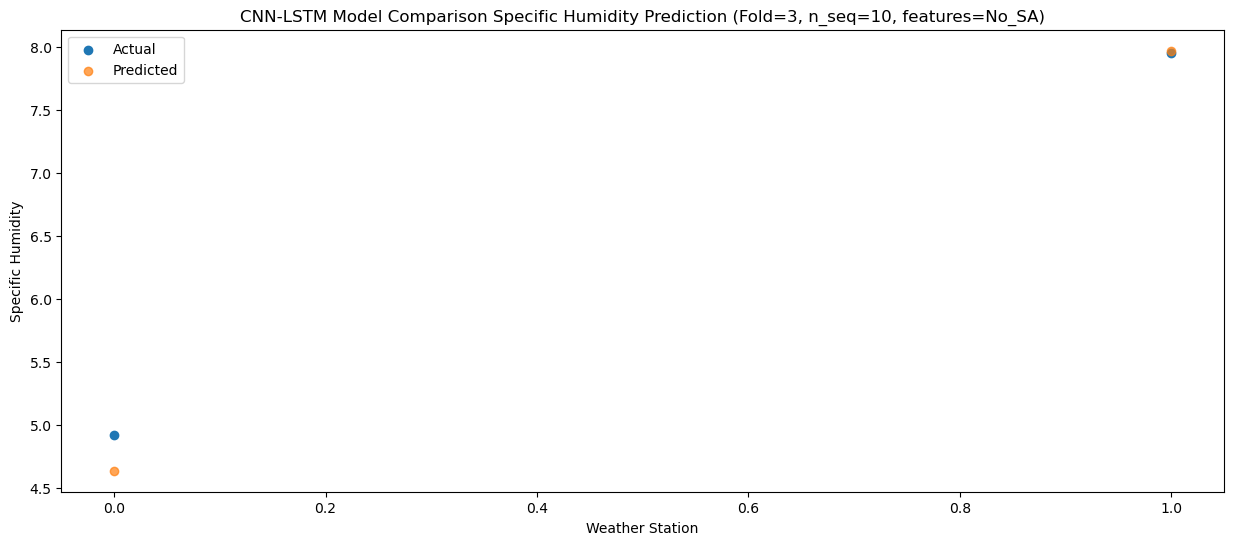

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   4.989209
1                1    8.59   8.631961


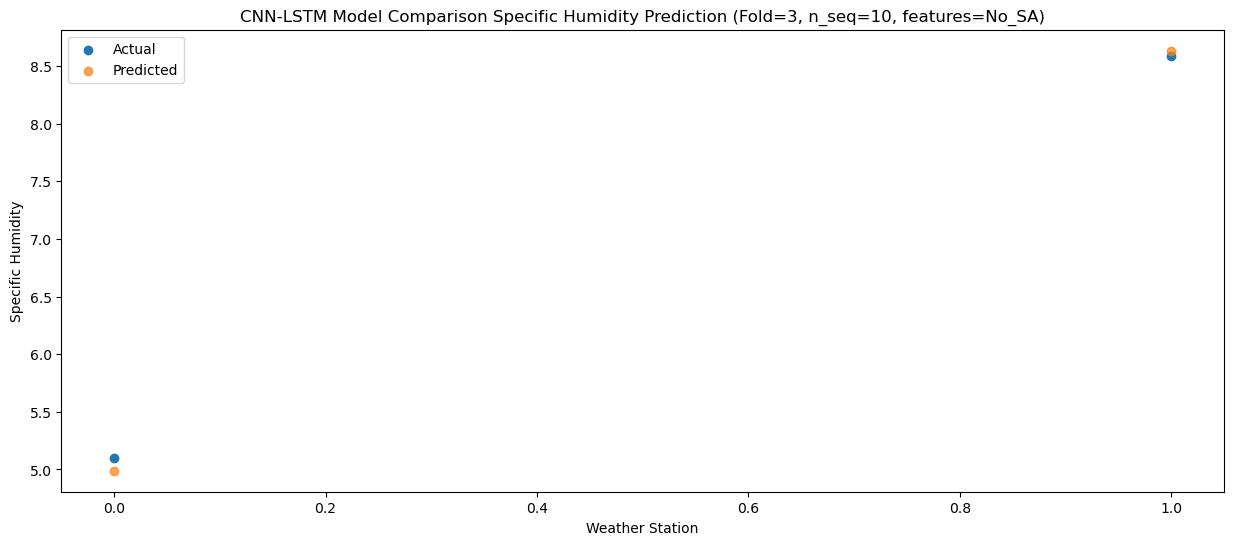

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.553463
1                1    8.69   8.681248


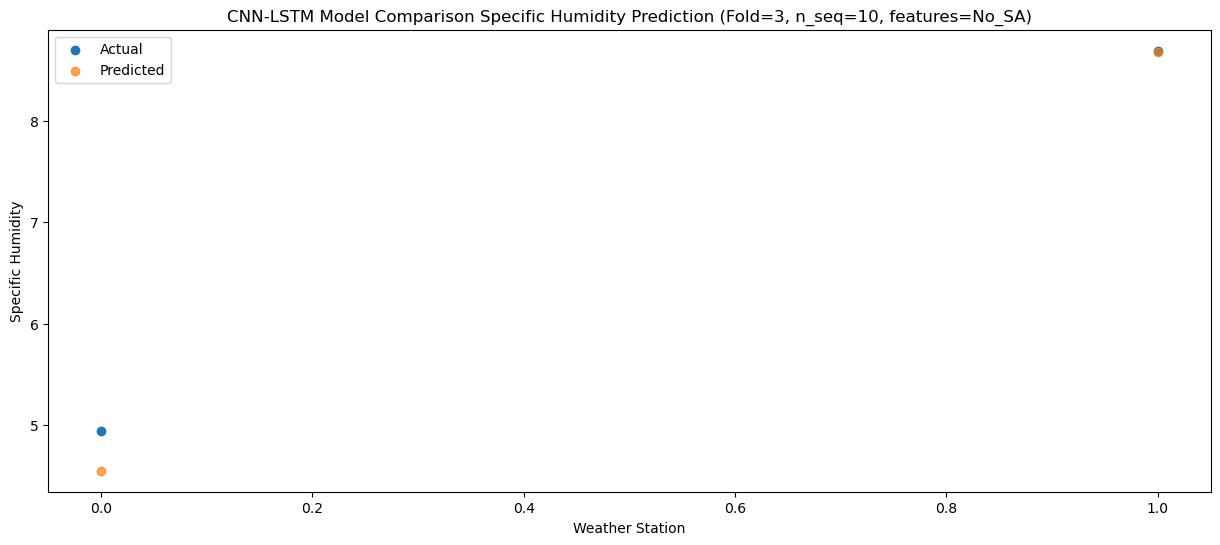

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.647636
1                1    8.51   8.720751


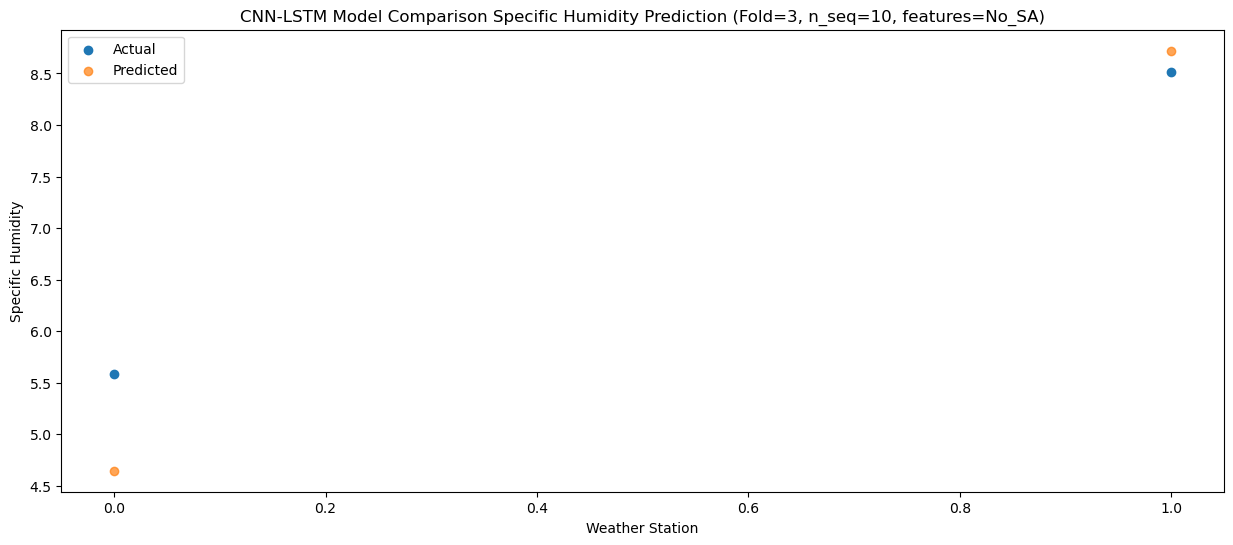

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   4.593451
1                1    8.87   9.092698


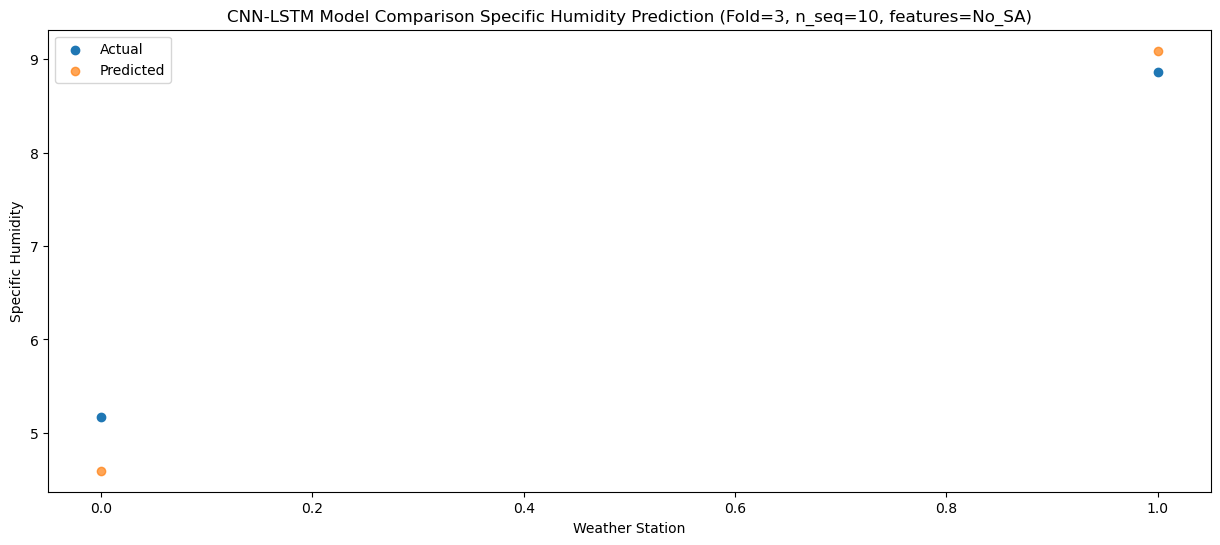

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.387529
1                1    8.75   8.664115


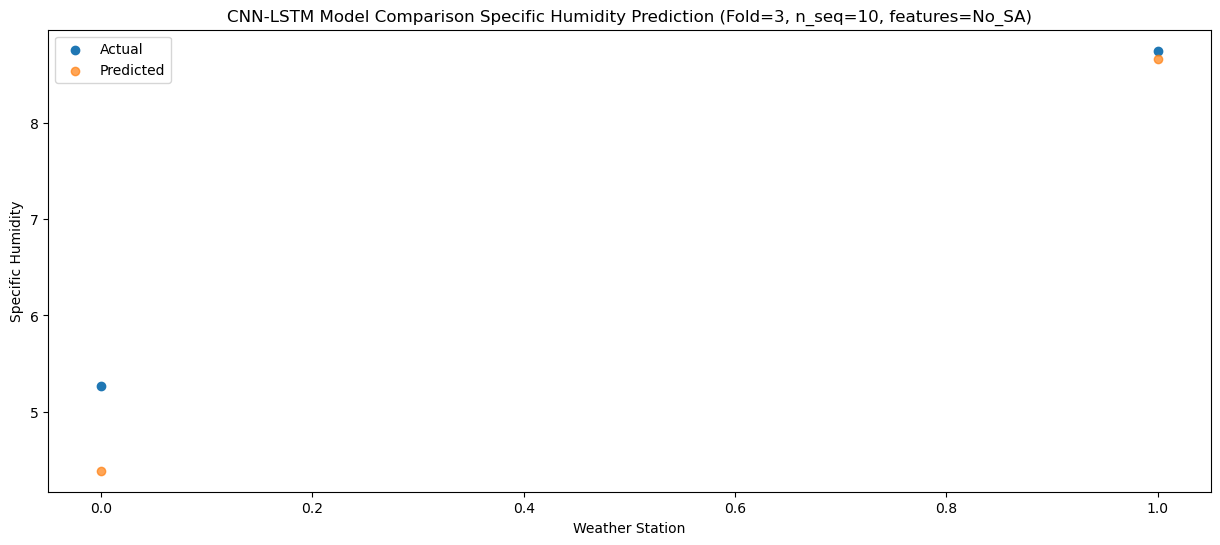

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.339865
1                1    8.66   8.576702


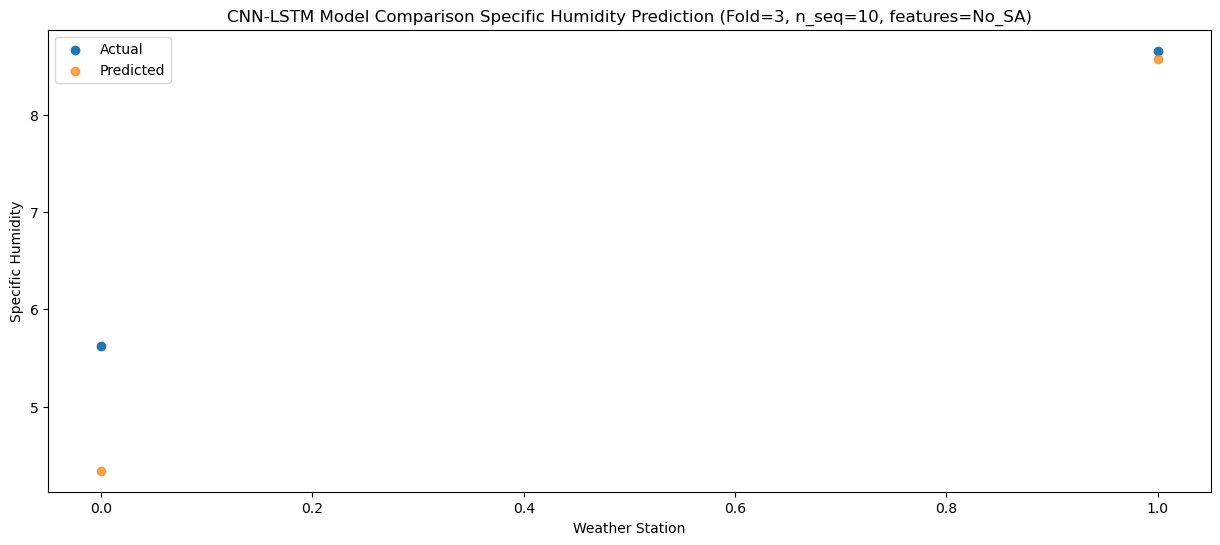

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.073850
1                1    8.63   8.468451


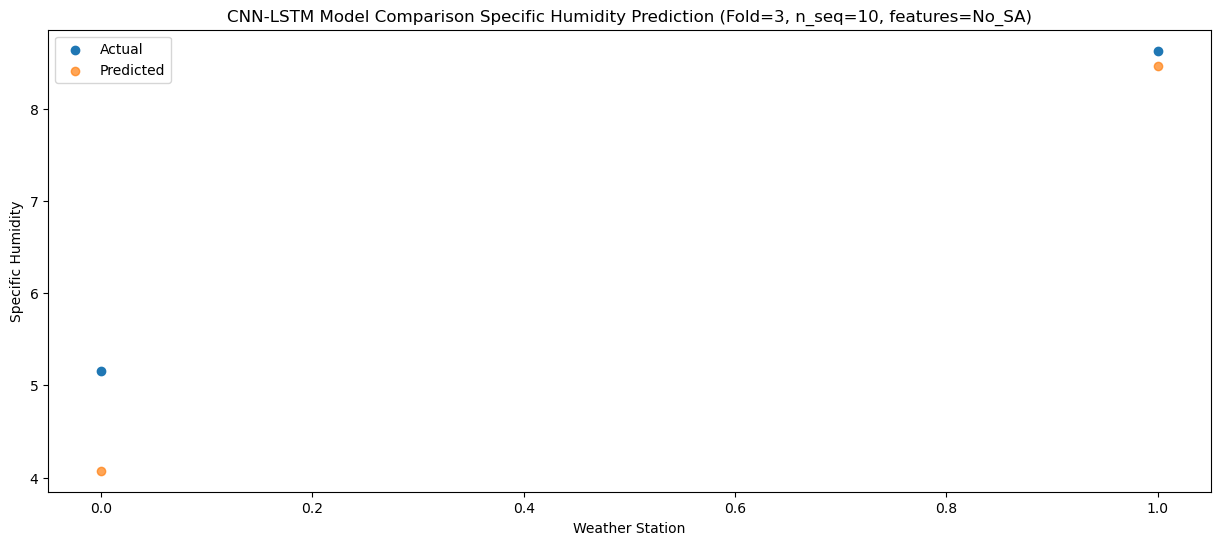

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.002150
1                1    8.16   8.220897


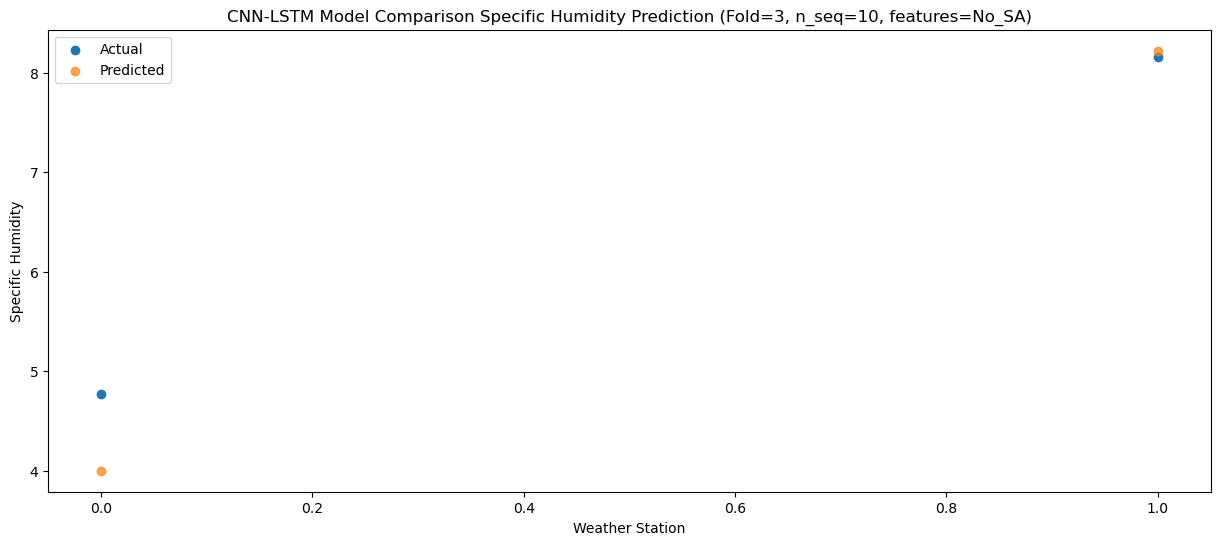

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.054766
1                1    8.18   8.346890


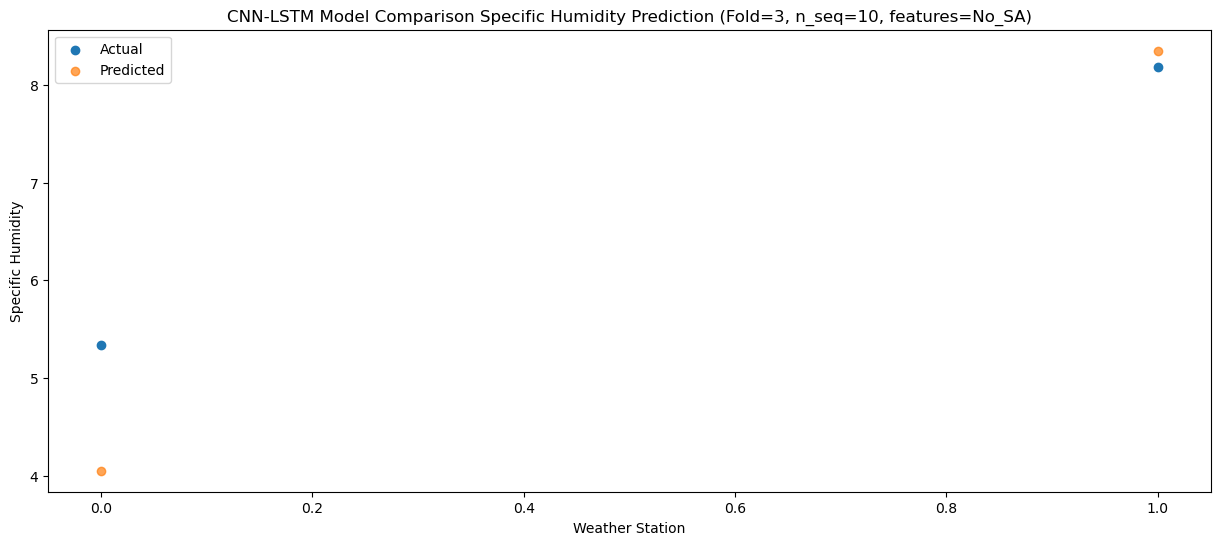

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.63630974 7.97028314]
 [4.98920884 8.63196121]
 [4.55346331 8.68124836]
 [4.64763607 8.72075056]
 [4.59345144 9.0926983 ]
 [4.38752892 8.6641151 ]
 [4.33986468 8.57670181]
 [4.07385049 8.46845117]
 [4.00215046 8.2208967 ]
 [4.05476627 8.34688995]]
Year at t+1:
t+1 SKRMSE: 0.201111
t+1 KRMSE: 0.201111
t+1 MAE: 0.151987
t+1 SKMAPE: 0.030106
t+1 R2_SCORE: 0.982378
t+1 KMAPE: 0.030106
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.083772
t+2 KRMSE: 0.083772
t+2 MAE: 0.076376
t+2 SKMAPE: 0.013304
t+2 R2_SCORE: 0.997695
t+2 KMAPE: 0.013304
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.273393
t+3 KRMSE: 0.273393
t+3 MAE: 0.197644
t+3 SKMAPE: 0.039627
t+3 R2_SCORE: 0.978740
t+3 KMAPE: 0.039627
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.682812
t+4 KRMSE: 0.6828

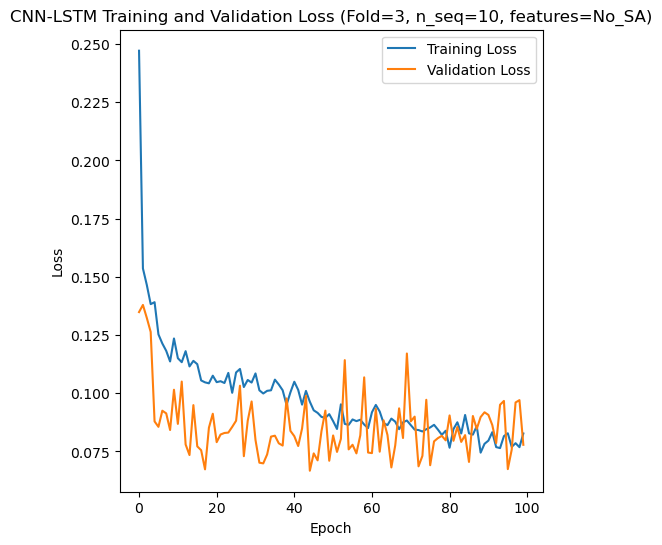

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 27s 491ms/step - loss: 0.1668 - accuracy: 0.4737 - mae: 0.1443 - rmse: 0.1668 - mape: 32.9809 - pearson: 0.2029 - val_loss: 0.1191 - val_accuracy: 0.0000e+00 - val_mae: 0.0950 - val_rmse: 0.1191 - val_mape: 21.5833 - val_pearson: 0.0945
Epoch 2/100
19/19 [==============================] - 3s 154ms/step - loss: 0.1015 - accuracy: 0.4211 - mae: 0.0845 - rmse: 0.1015 - mape: 19.8235 - pearson: 0.2879 - val_loss: 0.1098 - val_accuracy: 0.0000e+00 - val_mae: 0.0885 - val_rmse: 0.1098 - val_mape: 19.8239 - val_pearson: 0.0325
Epoch 3/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0924 -

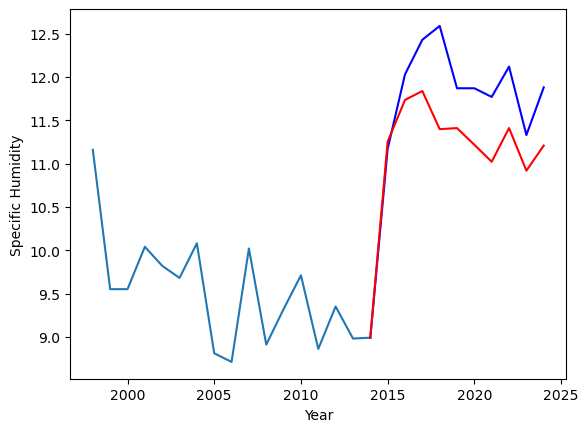

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.09		0.02
8.73		8.59		-0.14
9.20		8.72		-0.48
8.87		8.48		-0.39
9.27		8.68		-0.59
8.73		8.32		-0.41
8.46		8.28		-0.18
8.79		8.56		-0.23
8.19		8.14		-0.05
8.42		8.32		-0.10


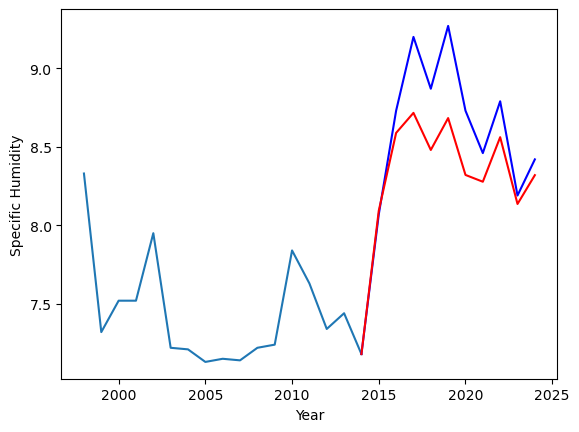

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  11.253454
1                1    8.07   8.093150


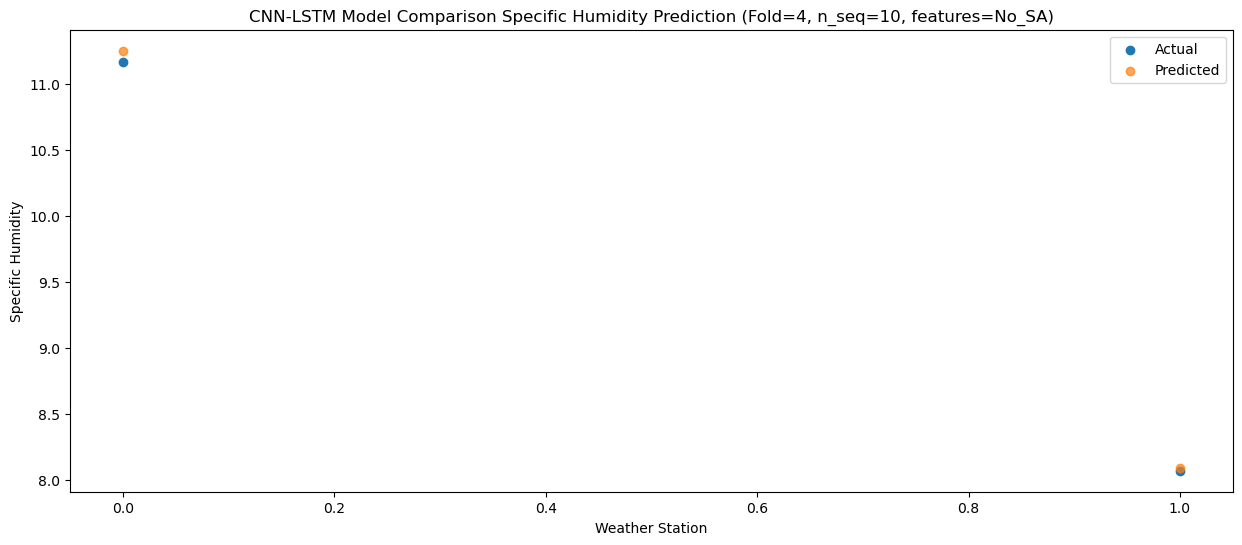

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.735471
1                1    8.73   8.588606


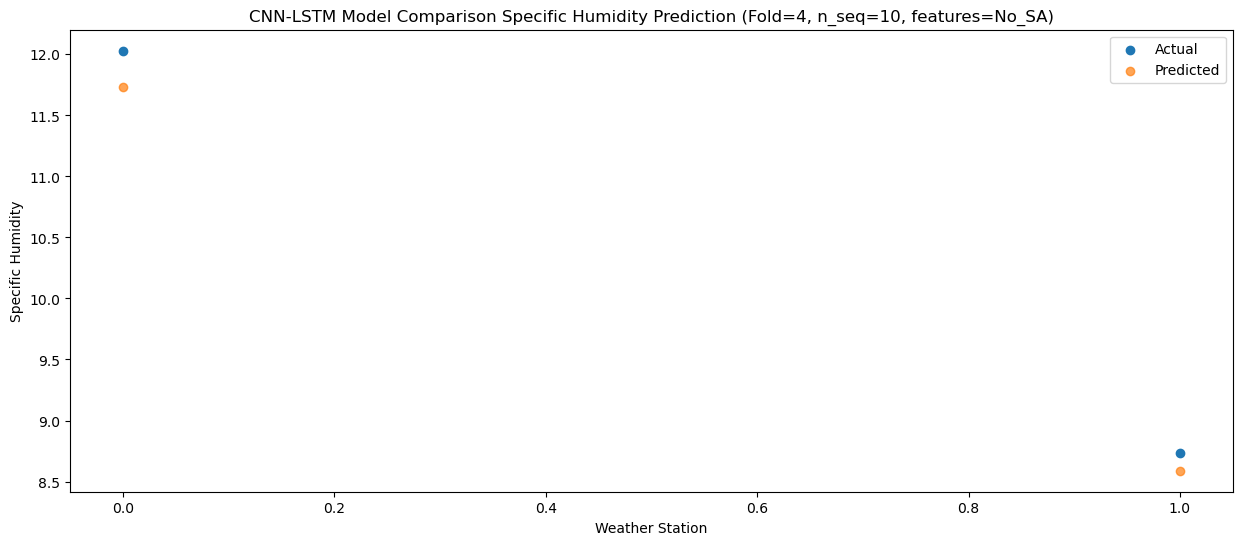

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.838196
1                1    9.20   8.716240


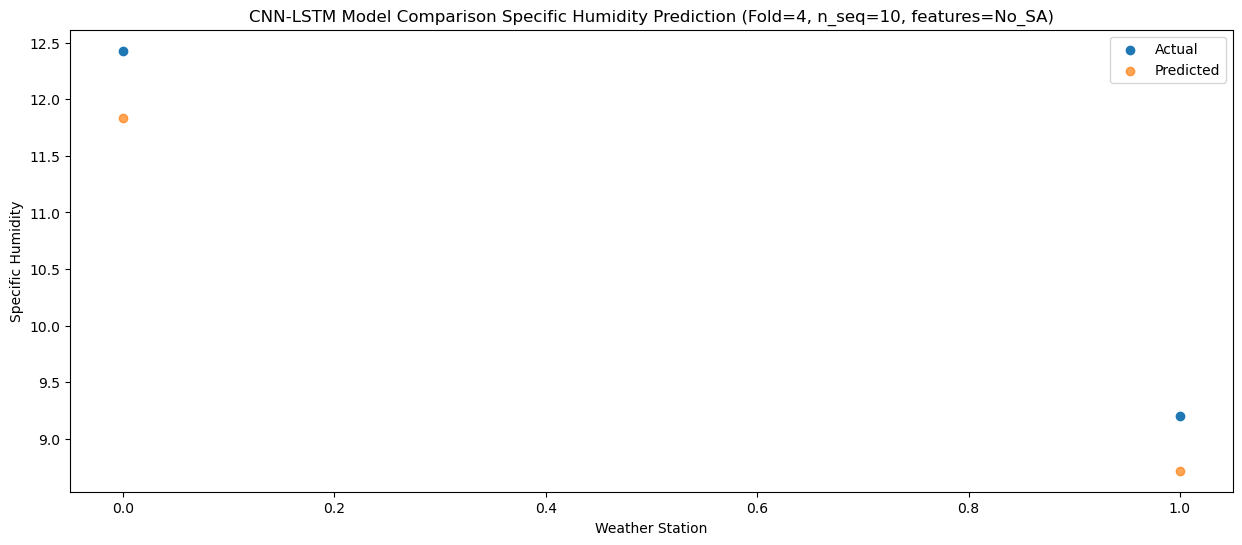

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59   11.39800
1                1    8.87    8.47994


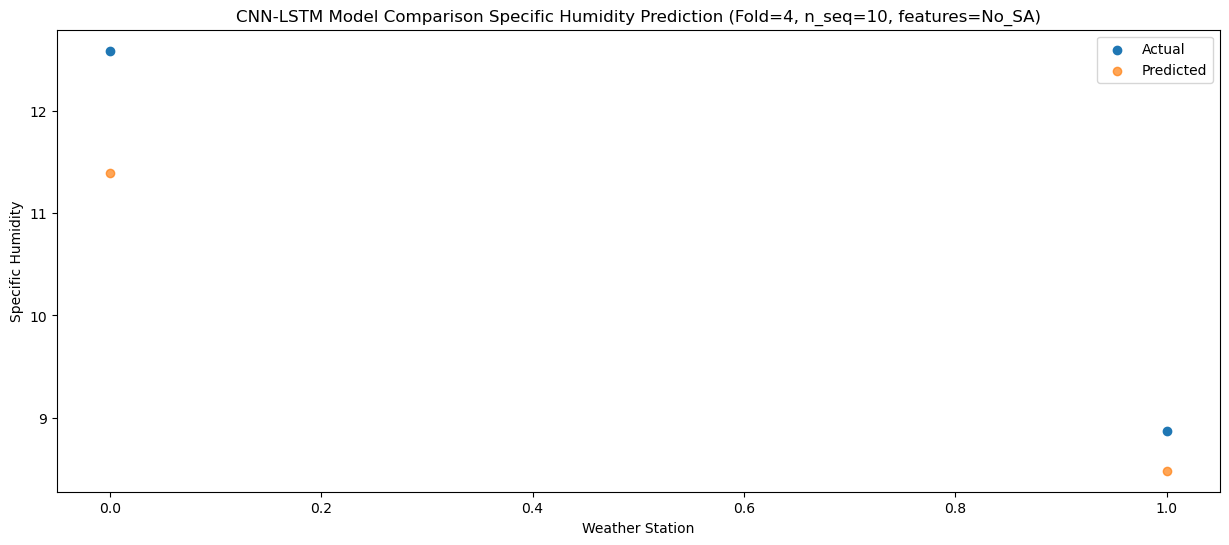

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.410135
1                1    9.27   8.683034


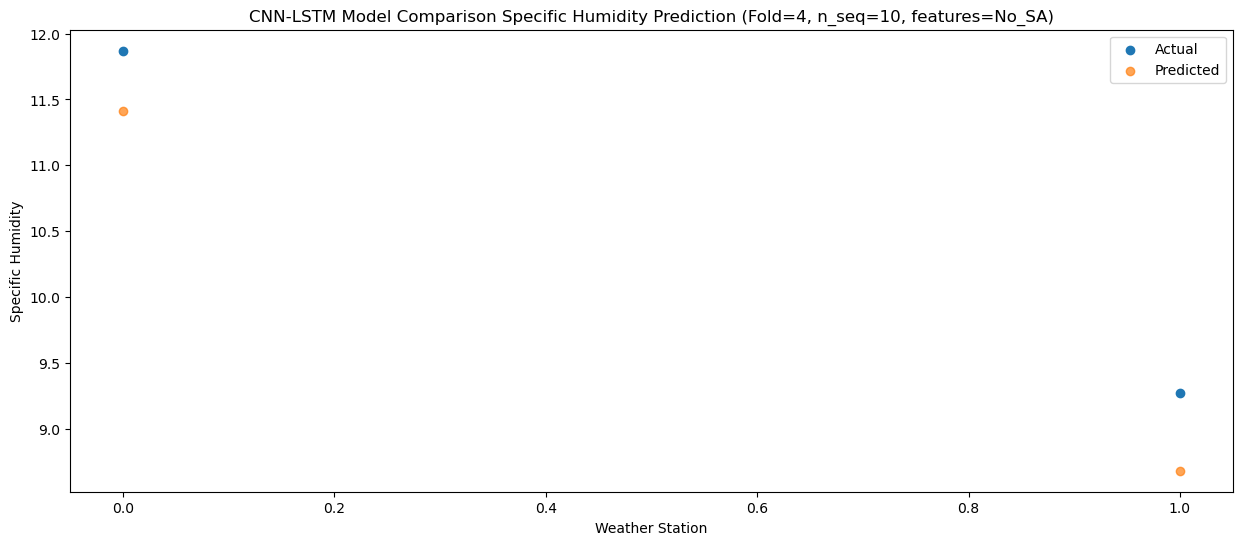

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.217480
1                1    8.73   8.320922


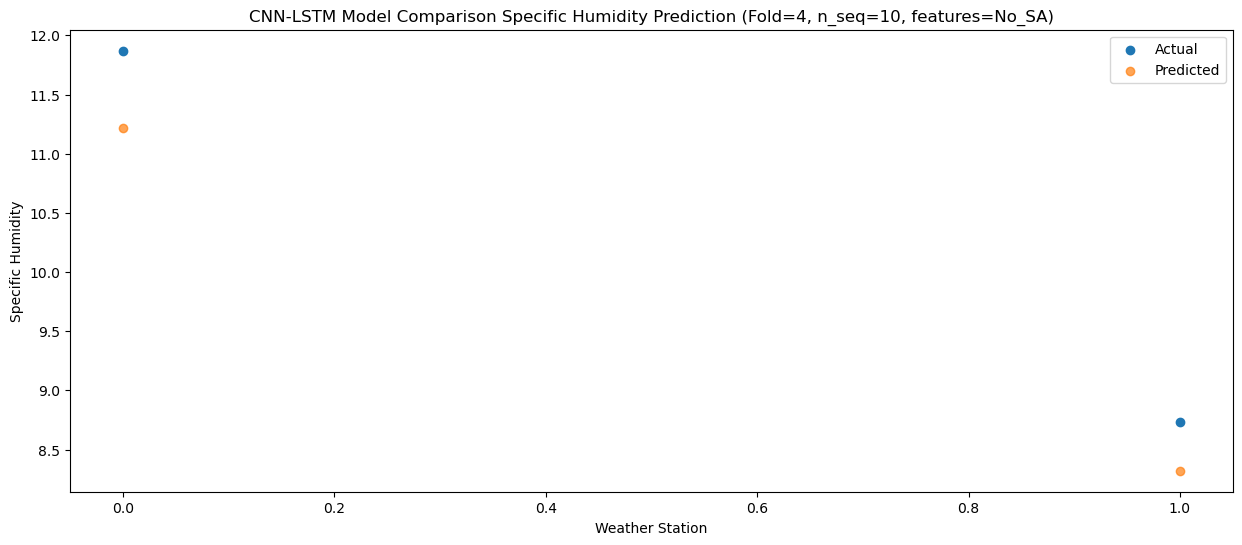

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.021485
1                1    8.46   8.277650


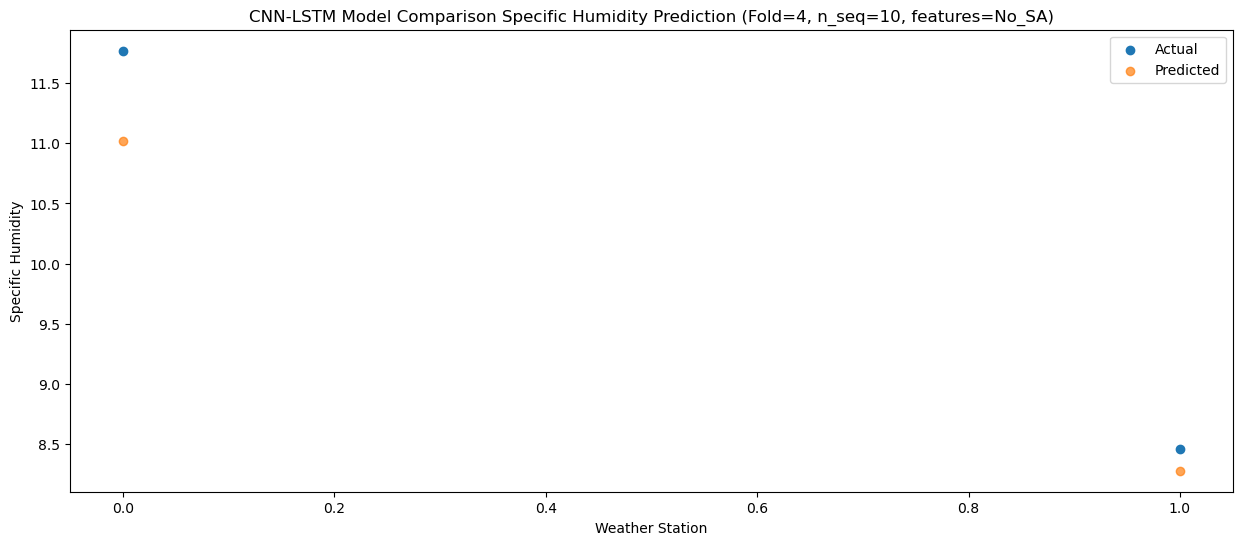

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.410625
1                1    8.79   8.561440


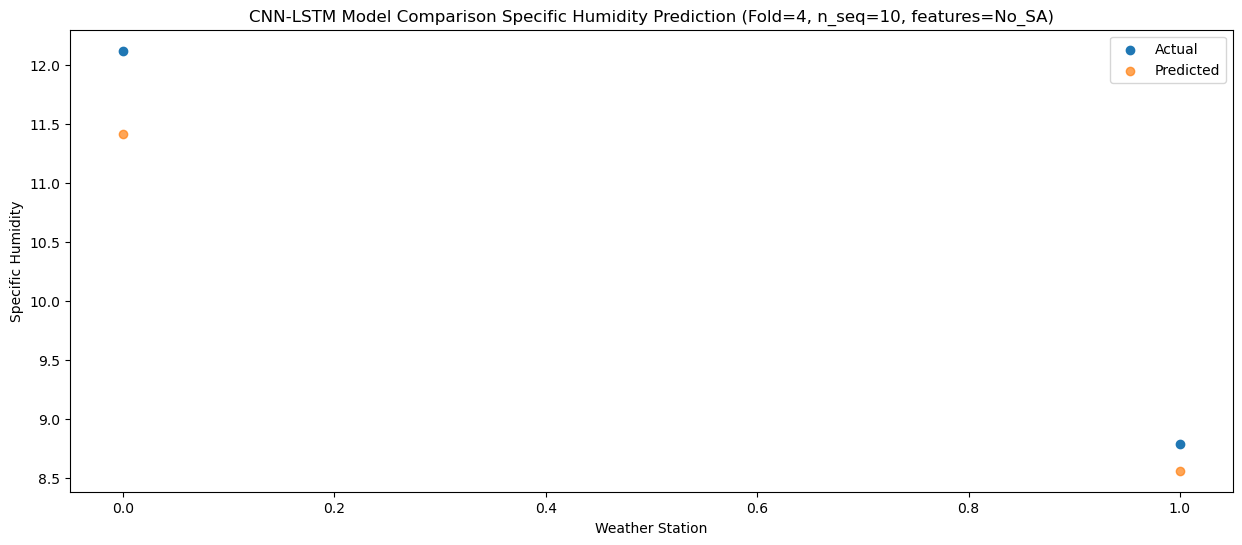

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  10.918569
1                1    8.19   8.136006


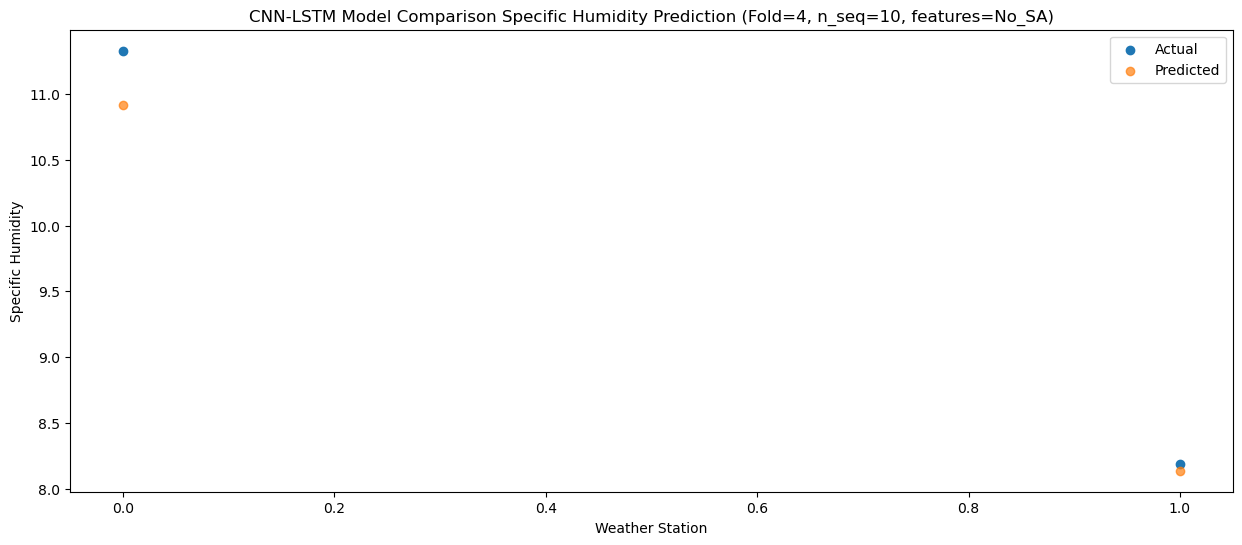

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.208128
1                1    8.42   8.319575


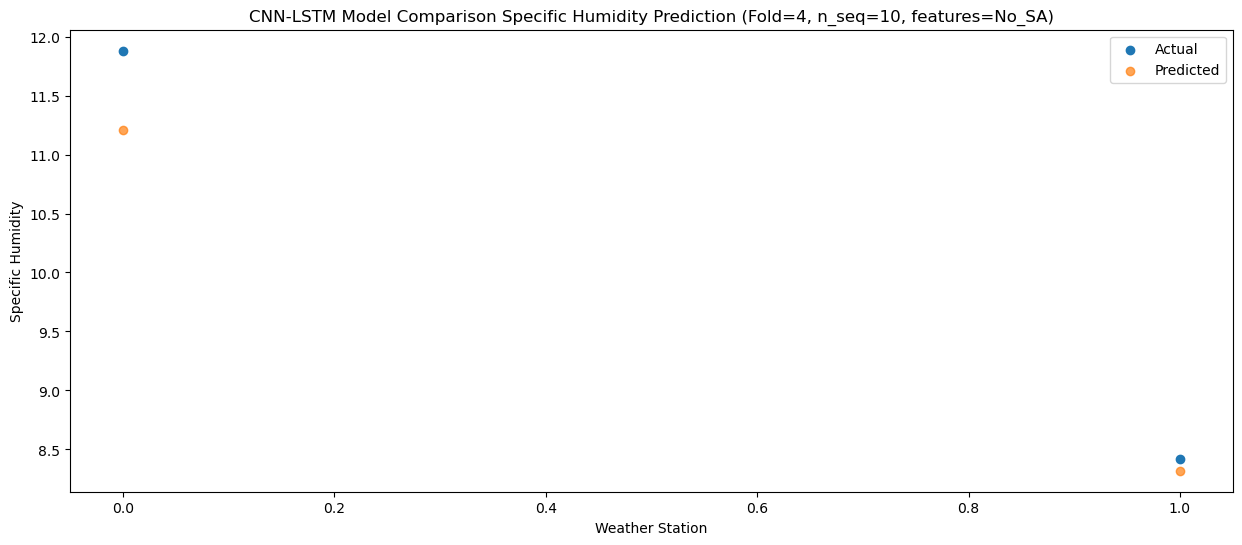

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[11.25345416  8.0931501 ]
 [11.73547141  8.58860614]
 [11.83819574  8.71624027]
 [11.39800039  8.47994042]
 [11.41013473  8.68303417]
 [11.21748021  8.32092212]
 [11.02148481  8.27764956]
 [11.41062476  8.56144045]
 [10.91856857  8.13600571]
 [11.20812784  8.31957505]]
Year at t+1:
t+1 SKRMSE: 0.061239
t+1 KRMSE: 0.061239
t+1 MAE: 0.053302
t+1 SKMAPE: 0.005170
t+1 R2_SCORE: 0.998439
t+1 KMAPE: 0.005170
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.231019
t+2 KRMSE: 0.231019
t+2 MAE: 0.217961
t+2 SKMAPE: 0.020340
t+2 R2_SCORE: 0.980397
t+2 KMAPE: 0.020340
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.540489
t+3 KRMSE: 0.540489
t+3 MAE: 0.537782
t+3 SKMAPE: 0.050097
t+3 R2_SCORE: 0.887997
t+3 KMAPE: 0.050097
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

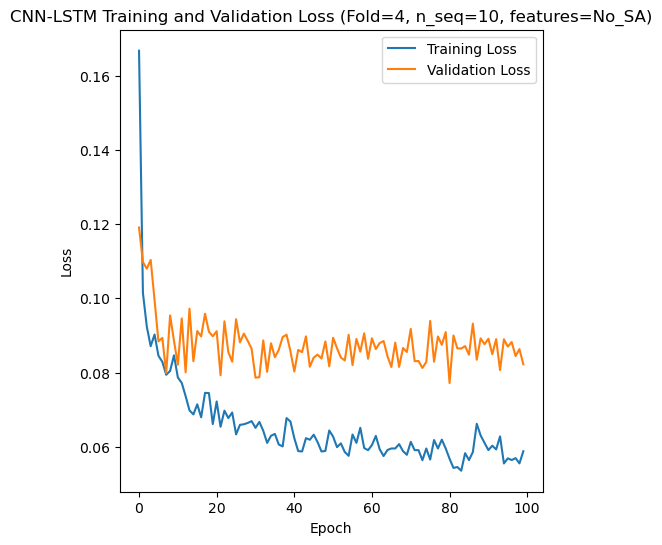

[[0.29939526822269785], [0.5641188262091699], [0.3258694707574387], [0.6111258913506367], [0.5100639591865246]]
[[array(0.29939527)], [array(0.56411883)], [array(0.32586947)], [array(0.61112589)], [array(0.51006396)]]
[[0.22928696123906428], [0.4678937085960057], [0.26568219701200735], [0.43323666091263313], [0.42075509612262174]]
[[0.018765261402907574], [0.04723297372673703], [0.027811046091707436], [0.07847230971985132], [0.03874134677014844]]
[[0.9624555609222804], [0.9127614074807948], [0.9112134494108644], [0.8673628113451284], [0.9060091489084134]]
[[array(0.01876526)], [array(0.04723297)], [array(0.02781105)], [array(0.07847231)], [array(0.03874135)]]
[[array(0.96520108)], [array(0.97341873)], [array(0.92334558)], [array(0.97580524)], [array(0.97627047)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82 

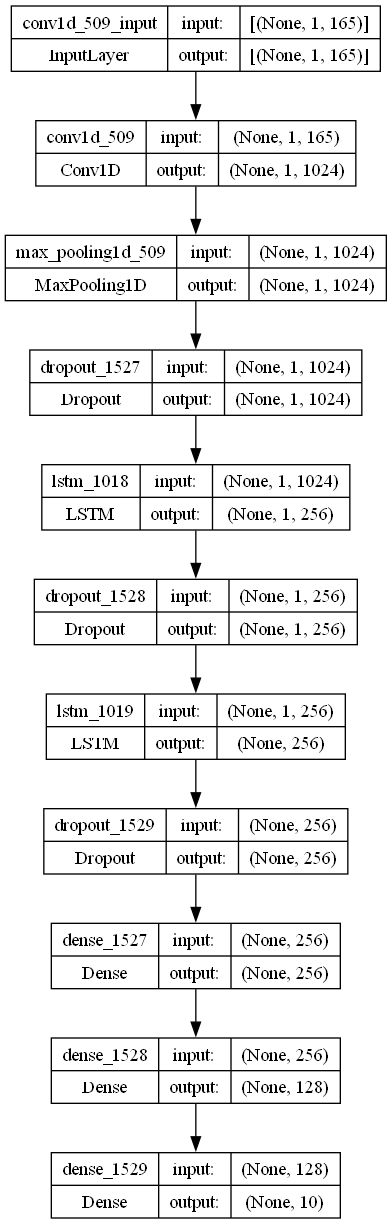

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.0011968925324844382
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.11132049236037105

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S10_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)